In [26]:
# Import necessary libraries
import matplotlib.pyplot as plt
import os
from skimage import io
import numpy as np
import pickle 
from scipy.ndimage import gaussian_filter1d
import cv2

Functions

In [161]:
import matplotlib.pyplot as plt

def plot_all_metrics(mask_dir, predict_dir):
    # get all the scores
    pixel_acc_scores = pixel_acc(mask_dir, predict_dir)
    dice_scores = dice_coef(mask_dir, predict_dir)
    precision_scores, recall_scores = precision_recall(mask_dir, predict_dir)

    # Now we plot
    plt.figure(figsize=(12, 12))

    def annotate_median(subplot, scores):
        median = np.median(scores)
        subplot.annotate(f'Median: {median:.2f}', xy=(0.85, 0.9), xycoords='axes fraction', fontsize=12, ha='center')

    subplot = plt.subplot(2, 2, 1)
    plt.boxplot(pixel_acc_scores)
    plt.title('Pixel Accuracy of UNET Predictions')
    plt.xlabel('UNET Model')
    plt.ylabel('Pixel Accuracy')
    annotate_median(subplot, pixel_acc_scores)

    subplot = plt.subplot(2, 2, 2)
    plt.boxplot(dice_scores)
    plt.title('Dice Coefficients of UNET Predictions')
    plt.xlabel('UNET Model')
    plt.ylabel('Dice Coefficient')
    annotate_median(subplot, dice_scores)

    subplot = plt.subplot(2, 2, 3)
    plt.boxplot(precision_scores)
    plt.title('Precision of UNET Predictions')
    plt.xlabel('UNET Model')
    plt.ylabel('Precision')
    annotate_median(subplot, precision_scores)

    subplot = plt.subplot(2, 2, 4)
    plt.boxplot(recall_scores)
    plt.title('Recall of UNET Predictions')
    plt.xlabel('UNET Model')
    plt.ylabel('Recall')
    annotate_median(subplot, recall_scores)

    plt.tight_layout()
    plt.show()

    
# this function evaluates pixel accuract of the predicted masks
def pixel_acc(mask_dir, predict_dir):
    # Get the list of all file names in the mask directory
    file_list = os.listdir(mask_dir)

    # Initialize an empty list to store accuracy scores
    accuracy_scores = []

    # Loop through all files
    for file in file_list:
        # skip any non-PNG file
        if not file.endswith('.png'):
            continue
        # Create file paths
        mask_file = os.path.join(mask_dir, file)
        predict_file = os.path.join(predict_dir, file)

        # Load the images
        mask_img = io.imread(mask_file)
        predict_img = io.imread(predict_file)
        
        # Check max of images before normalization
        if np.max(mask_img) != 0:
            mask_img = mask_img / np.max(mask_img)
        if np.max(predict_img) != 0:
            predict_img = predict_img / np.max(predict_img)
        
        # Make sure that the mask and prediction are binary (0 and 1)
        mask_img = (mask_img > 0.5).astype(np.uint8)
        predict_img = (predict_img > 0.5).astype(np.uint8)
        
        # Calculate pixel accuracy
        correct_pixels = np.sum(mask_img == predict_img)
        total_pixels = mask_img.shape[0] * mask_img.shape[1]
        accuracy = correct_pixels / total_pixels

        # Append to accuracy scores list
        accuracy_scores.append(accuracy)
    
    return accuracy_scores


# this function evaluates Dice coefficient of the predicted masks
def dice_coef(mask_dir, predict_dir):
    # Get the list of all file names in the mask directory
    file_list = os.listdir(mask_dir)

    # Initialize an empty list to store Dice scores
    dice_scores = []

    # Loop through all files
    for file in file_list:
        # Skip any non-PNG files
        if not file.endswith('.png'):
            continue

        # Create file paths
        mask_file = os.path.join(mask_dir, file)
        predict_file = os.path.join(predict_dir, file)

        dice = dice_coef_single(mask_file, predict_file)
        # Append to Dice scores list
        dice_scores.append(dice)

    return dice_scores


# this function calculates dice coefficient of a single predicted mask and returns the dice score
def dice_coef_single(mask_file, predict_file):
    # Load the images
    mask_img = io.imread(mask_file)
    predict_img = io.imread(predict_file)
    
    # Check max of images before normalization
    if np.max(mask_img) != 0:
        mask_img = mask_img / np.max(mask_img)
    if np.max(predict_img) != 0:
        predict_img = predict_img / np.max(predict_img)
    
    # Make sure that the mask and prediction are binary (0 and 1)
    mask_img = (mask_img > 0.5).astype(np.uint8)
    predict_img = (predict_img > 0.5).astype(np.uint8)

    # if both ground truth and prediction are all zeros, then dice score is 1
    if np.sum(mask_img) == 0 and np.sum(predict_img) == 0:
        return 1.0
    
    intersection = np.sum(predict_img * mask_img)
    dice = (2. * intersection) / (np.sum(predict_img) + np.sum(mask_img) + 1e-6)

    return dice
    

# this function evaluates precision and recall of the predicted masks
def precision_recall(mask_dir, predict_dir):
    # Get the list of all file names in the mask directory
    file_list = os.listdir(mask_dir)

    # Initialize empty lists to store Precision and Recall scores
    precision_scores = []
    recall_scores = []

    # Loop through all files
    for file in file_list:
        # Skip any non-PNG files
        if not file.endswith('.png'):
            continue

        # Create file paths
        mask_file = os.path.join(mask_dir, file)
        predict_file = os.path.join(predict_dir, file)

        # Load the images
        mask_img = io.imread(mask_file)
        predict_img = io.imread(predict_file)
        
        # Check max of images before normalization
        if np.max(mask_img) != 0:
            mask_img = mask_img / np.max(mask_img)
        if np.max(predict_img) != 0:
            predict_img = predict_img / np.max(predict_img)
        
        # Make sure that the mask and prediction are binary (0 and 1)
        mask_img = (mask_img > 0.5).astype(np.uint8)
        predict_img = (predict_img > 0.5).astype(np.uint8)
        
        # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
        TP = np.sum((predict_img == 1) & (mask_img == 1))
        FP = np.sum((predict_img == 1) & (mask_img == 0))
        FN = np.sum((predict_img == 0) & (mask_img == 1))
        
        # Calculate Precision and Recall scores and append to respective lists
        if (TP + FP) > 0:
            precision = TP / (TP + FP)
            precision_scores.append(precision)
        
        if (TP + FN) > 0:
            recall = TP / (TP + FN)
            recall_scores.append(recall)
    return precision_scores, recall_scores


def postprocess_masks(input_folder, output_folder):
    # Create the output folder if not exists
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    # Iterate through the files in the input directory
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            filepath = os.path.join(input_folder, filename)
                
            # Read the mask image in grayscale
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

            # Apply a median filter to reduce noise
            median_image = cv2.medianBlur(image, 5)

            # Threshold the image
            _, thresh_image = cv2.threshold(median_image, 127, 255, cv2.THRESH_BINARY)

            # Find the contours
            contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Find the largest contour and approximate it
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                epsilon = 0.02 * cv2.arcLength(largest_contour, True)
                approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)

                # Create a blank mask and draw the filled, approximated contour
                final_mask = np.zeros_like(image)
                cv2.drawContours(final_mask, [approx_contour], -1, 255, thickness=cv2.FILLED)

                # Save the processed image
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, final_mask)

                print(f'Processed {filename}')

    print('Postprocessing completed.')


def postprocess_masks(input_folder, output_folder):
    # Create the output folder if not exists
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    # Iterate through the files in the input directory
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            filepath = os.path.join(input_folder, filename)

            # Read the mask image in grayscale
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

            # Apply a median filter to reduce noise
            median_image = cv2.medianBlur(image, 5)

            # Threshold the image
            _, thresh_image = cv2.threshold(median_image, 127, 255, cv2.THRESH_BINARY)

            # Find contours
            contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Find the largest contour
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)

                # Smooth the contour using Gaussian filtering
                smooth_contour = gaussian_filter1d(largest_contour.squeeze(), sigma=5, axis=0)
                smooth_contour = smooth_contour.reshape(-1, 1, 2).astype(np.int32)

                # Create a blank mask and draw the filled, smoothed contour
                final_mask = np.zeros_like(image)
                cv2.drawContours(final_mask, [smooth_contour], -1, 255, thickness=cv2.FILLED)

                # Save the processed image
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, final_mask)
            # if no contours found, save the original image
            else:
                cv2.imwrite(os.path.join(output_folder, filename), image)

    print('Postprocessing completed.')



# plot predictions with ground truth and images
def plot_predictions(img_dir, mask_dir, predict_dir, n):
    # plot the first 10 img with ground truth mask and predicted mask
    for i in range(n): 
        # define file paths
        img_file = os.path.join(img_dir, os.listdir(img_dir)[i])
        mask_file = os.path.join(mask_dir, os.listdir(mask_dir)[i])
        predict_file = os.path.join(predict_dir, os.listdir(predict_dir)[i])
        
        # load the images
        img = io.imread(img_file, as_gray=True)
        mask = io.imread(mask_file, as_gray=True)
        predict = io.imread(predict_file, as_gray=True)
        
        # plot the images
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.imshow(img, cmap='gray')
        plt.title('Image')
        plt.subplot(1,3,2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.subplot(1,3,3)
        plt.imshow(predict, cmap='gray')
        plt.title('Predicted Mask')
        plt.tight_layout()
        plt.show()
        # print the dice score of this prediction
        print(f"Dice score: {dice_coef_single(mask_file, predict_file)}")

# plot the loss and accuracy curves
def plot_curves(history_dir):
    with open(history_dir, 'rb') as file:
        loaded_history = pickle.load(file)

    # Access training loss, test loss, and dice score
    train_loss = loaded_history["train_loss"]
    test_loss = loaded_history["test_loss"]
    test_dice = loaded_history["test_dice"]

    test_dice = [t.cpu().numpy() for t in test_dice]

    # Plot the training and test loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(train_loss, label="Train Loss", color='blue')
    plt.plot(test_loss, label="Test Loss", color='red')
    plt.title("Training and Test Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(test_dice, label="Test Dice Score", color='green')
    plt.title("Test Dice Score")
    plt.xlabel("Epoch #")
    plt.ylabel("Dice Score")
    plt.legend()

    # Show the plots
    plt.tight_layout()  # Adjust layout for better visualization
    plt.show()

def get_abnormality_matrix_and_plot_metrics(ground_truth_dir, predicted_dir):
    # Initialize an empty list to store the results
    result_matrix = []
    
    # Initialize variables to calculate metrics
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # Loop over each file in the ground truth directory
    for filename in os.listdir(ground_truth_dir):
        # Only proceed if the file is an image (assuming they are .png files)
        if filename.endswith('.png'):
            # Prepare the full path for both ground truth and predicted images
            gt_path = os.path.join(ground_truth_dir, filename)
            pred_path = os.path.join(predicted_dir, filename)
            
            # Read the ground truth and predicted images
            gt_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
            pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
            
            # Check if the images are abnormal (i.e., contain any non-zero pixel)
            is_abnormal_gt = np.any(gt_img > 0)
            is_abnormal_pred = np.sum(pred_img > 0) / (pred_img.shape[0] * pred_img.shape[1]) > 0.01
            
            # Append the result to our result_matrix
            result_matrix.append([filename, int(is_abnormal_gt), int(is_abnormal_pred)])
            
            # Update TP, TN, FP, FN
            if is_abnormal_gt and is_abnormal_pred:
                TP += 1
            elif not is_abnormal_gt and not is_abnormal_pred:
                TN += 1
            elif is_abnormal_gt and not is_abnormal_pred:
                FN += 1
            elif not is_abnormal_gt and is_abnormal_pred:
                FP += 1
    
    # Convert the list to a numpy array for easier manipulation later if needed
    result_matrix = np.array(result_matrix)
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    # Plot metrics
    metrics = [accuracy, precision, recall, F1]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    plt.figure(figsize=(10, 6))
    plt.bar(metric_names, metrics)
    plt.ylim([0, 1])
    for i, v in enumerate(metrics):
        plt.text(i, v - 0.05, "{:.2f}".format(v), color='white', ha='center', va='bottom')
    plt.title('Classification Metrics for Abnormal Scans')
    plt.show()

def overlay_images(image_dir, ground_truth_dir, predicted_dir, num_to_plot):
    num_rows = num_to_plot // 2 + num_to_plot % 2
    fig_height = num_rows * 4  # 4 units per row for better visibility

    # Prepare the subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, fig_height))

    # Flatten the axes for easier iteration
    axes = axes.flatten()

    filenames = os.listdir(ground_truth_dir)[:num_to_plot]
    plot_count = 0

    for i, filename in enumerate(filenames):
        # Assuming files are .png; update if you use a different file type
        if filename.endswith('.png'):
            # Read image, ground truth, and prediction
            image = cv2.imread(os.path.join(image_dir, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gt_mask = cv2.imread(os.path.join(ground_truth_dir, filename), cv2.IMREAD_GRAYSCALE)
            pred_mask = cv2.imread(os.path.join(predicted_dir, filename), cv2.IMREAD_GRAYSCALE)
            
            # Overlay ground truth on the image
            overlay_image = image.copy()
            overlay_image[gt_mask > 0] = [0, 255, 0]
            
            # Determine if the scan is abnormal or normal
            is_abnormal_gt = "Abnormal" if np.any(gt_mask > 0) else "Normal"
            is_abnormal_pred = "Abnormal" if np.sum(pred_mask > 0) / (pred_mask.shape[0] * pred_mask.shape[1]) > 0.01 else "Normal"

            text_color = "red" if is_abnormal_gt != is_abnormal_pred else "black"

            # Plot the overlay image
            ax = axes[plot_count]
            ax.imshow(overlay_image)
            ax.axis('off')
            ax.text(0.5, -0.1, f"Ground Truth: {is_abnormal_gt}, Prediction: {is_abnormal_pred}", 
                    size=12, ha="center", transform=ax.transAxes, color=text_color)
            
            plot_count += 1

    # Remove any extra subplots
    for ax in axes[plot_count:]:
        ax.axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.show()


### MR

Evaluation (with post-processing)

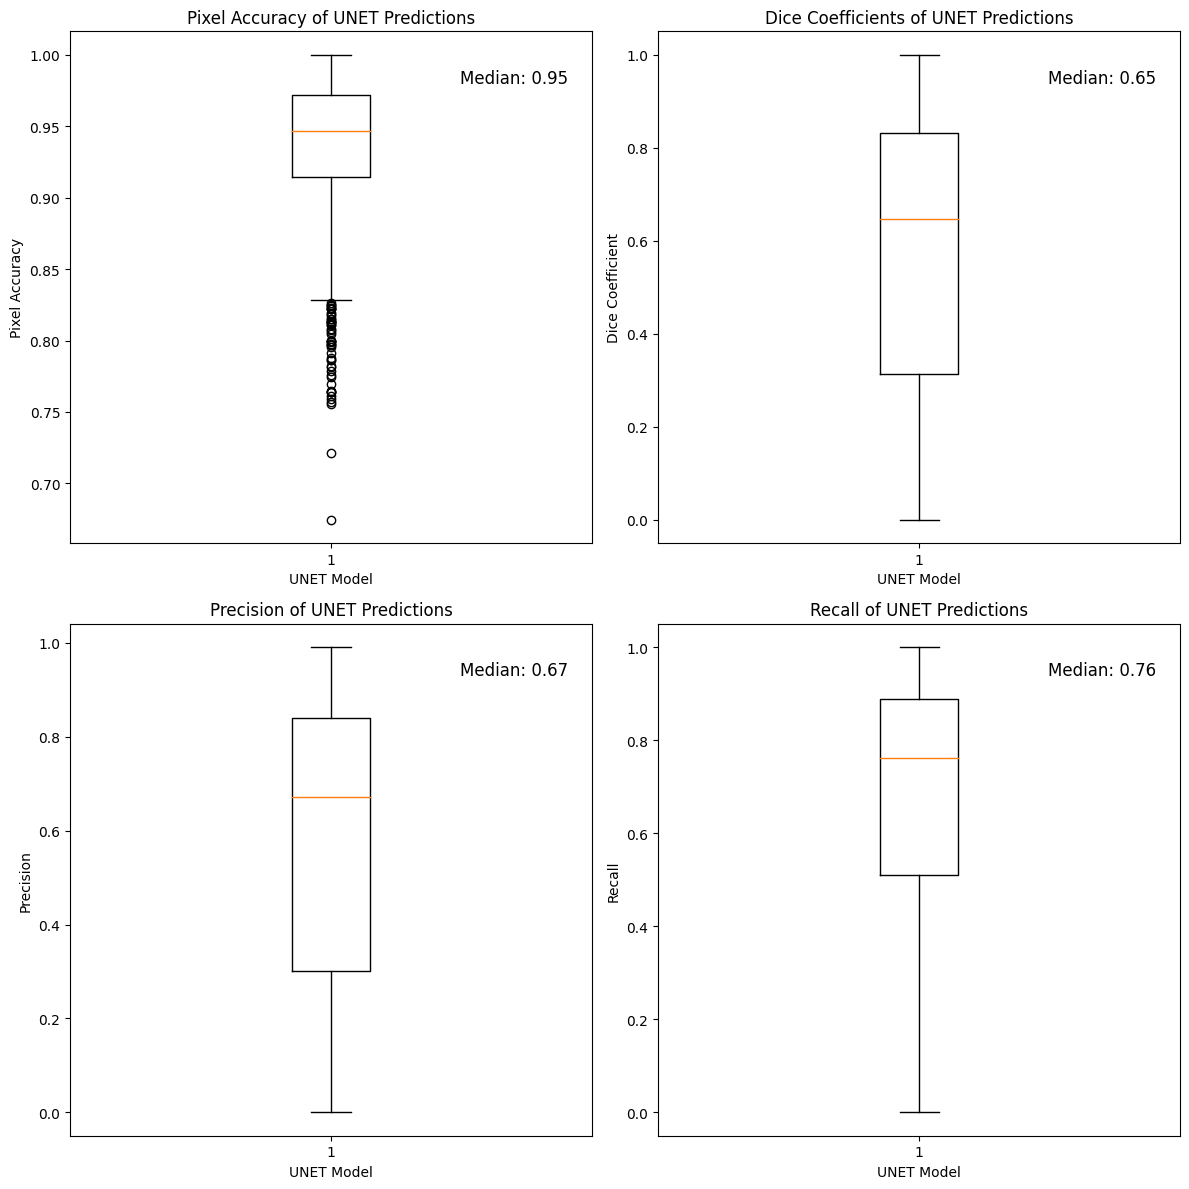

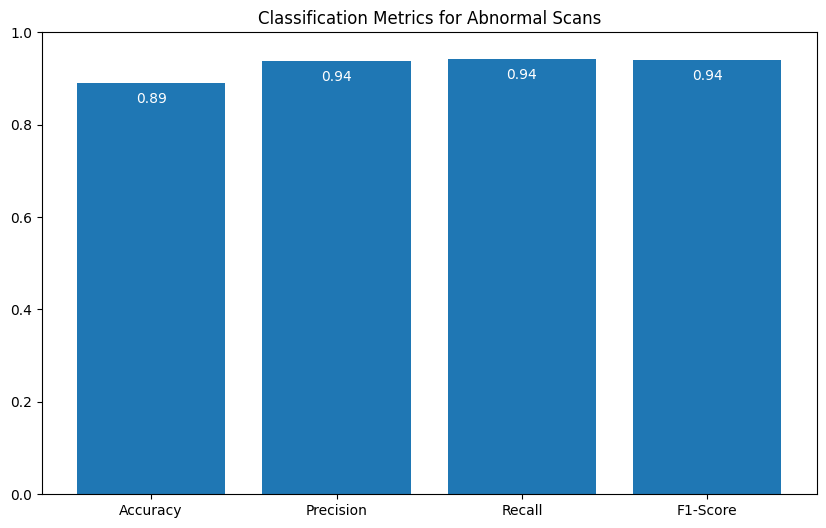

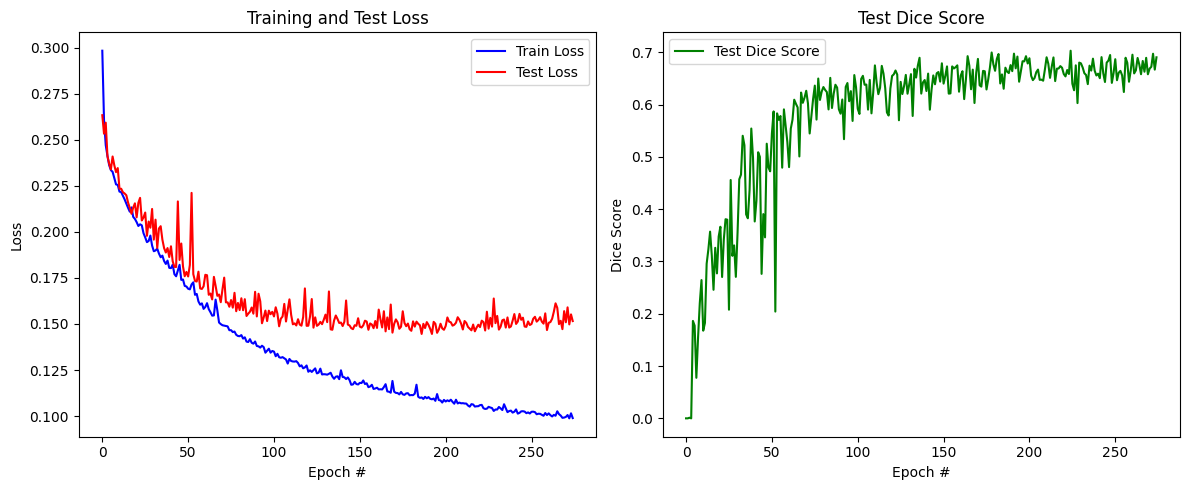

In [163]:
# Define the directories
img_dir = 'dataset_mr/test/images'
mask_dir = 'dataset_mr/test/mask'
post_predict_dir = 'dataset_mr/test/predict_unet_postprocess'
predict_dir = 'dataset_mr/test/predict_unet'
training_history_dir = 'dataset_mr/model_unet/history.pkl'

plot_all_metrics(mask_dir, predict_dir)
get_abnormality_matrix_and_plot_metrics(mask_dir, predict_dir)
plot_curves(training_history_dir)

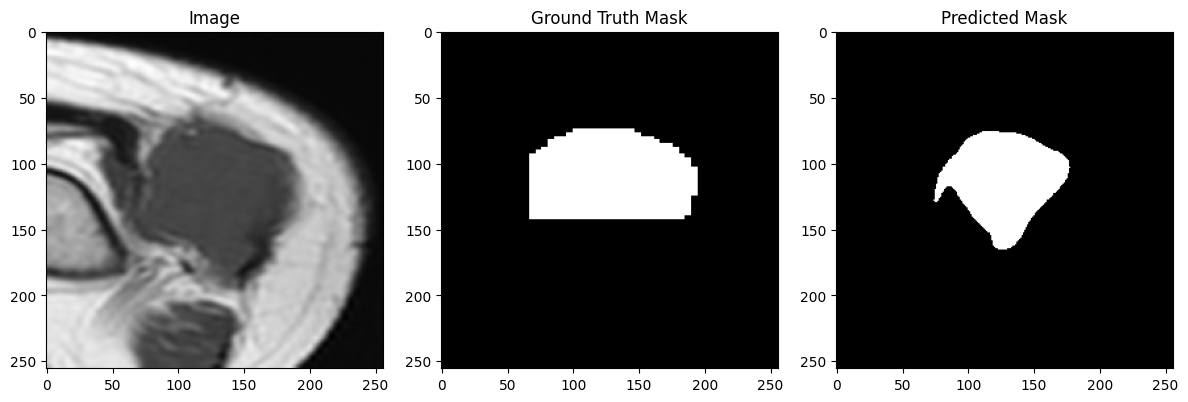

Dice score: 0.7379622640952481


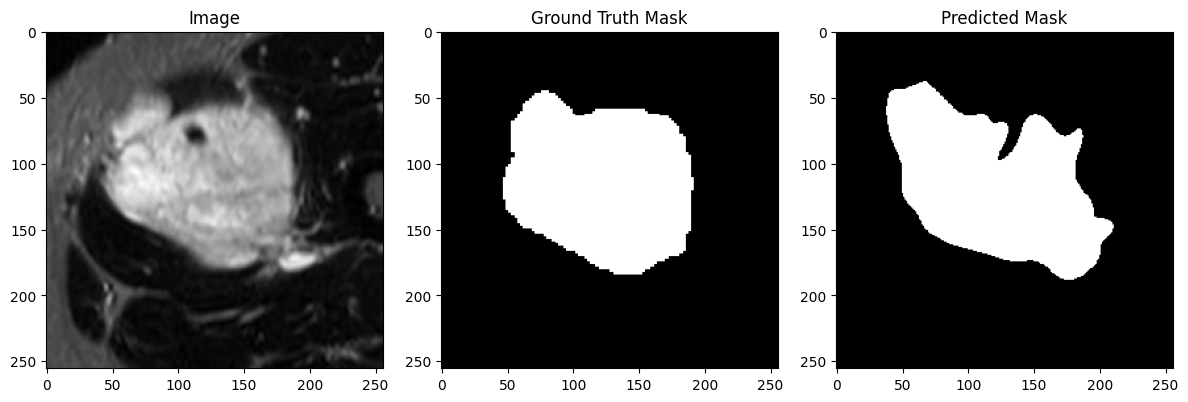

Dice score: 0.8669860226764556


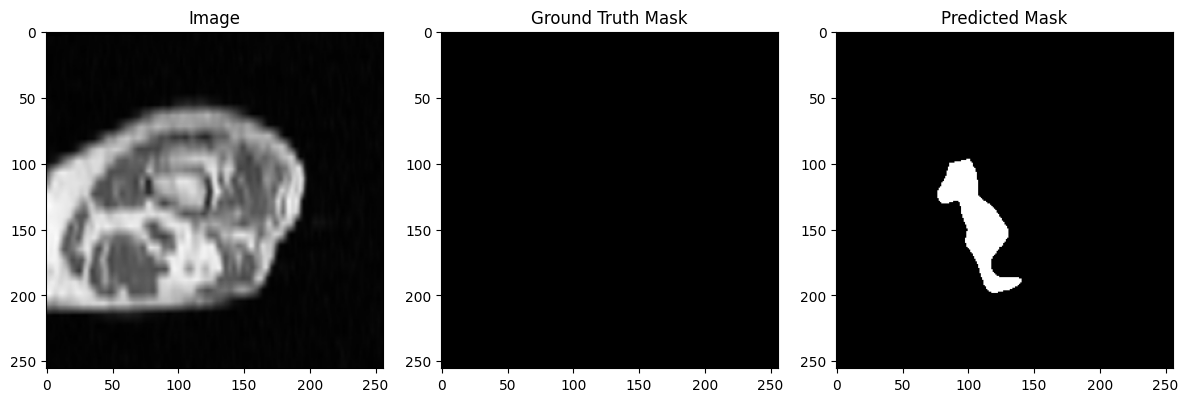

Dice score: 0.0


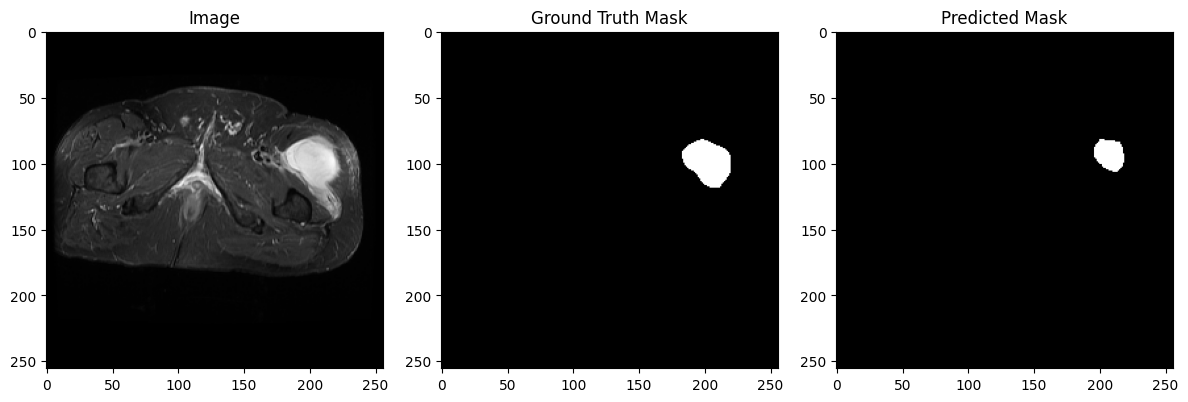

Dice score: 0.5554760196453286


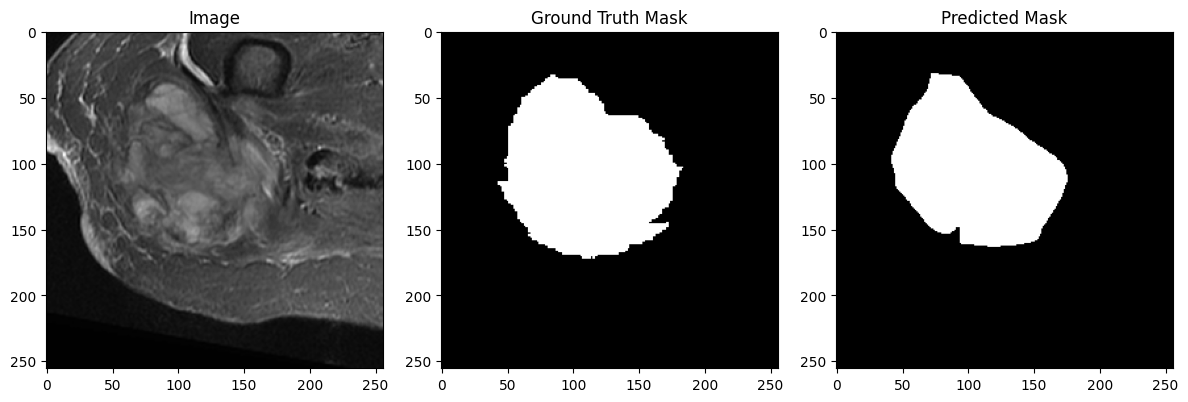

Dice score: 0.8984143719981177


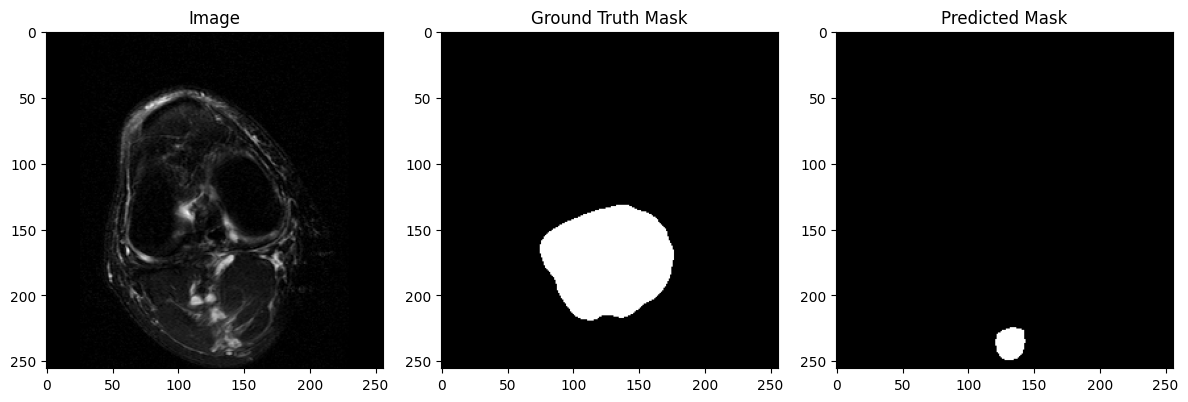

Dice score: 0.0


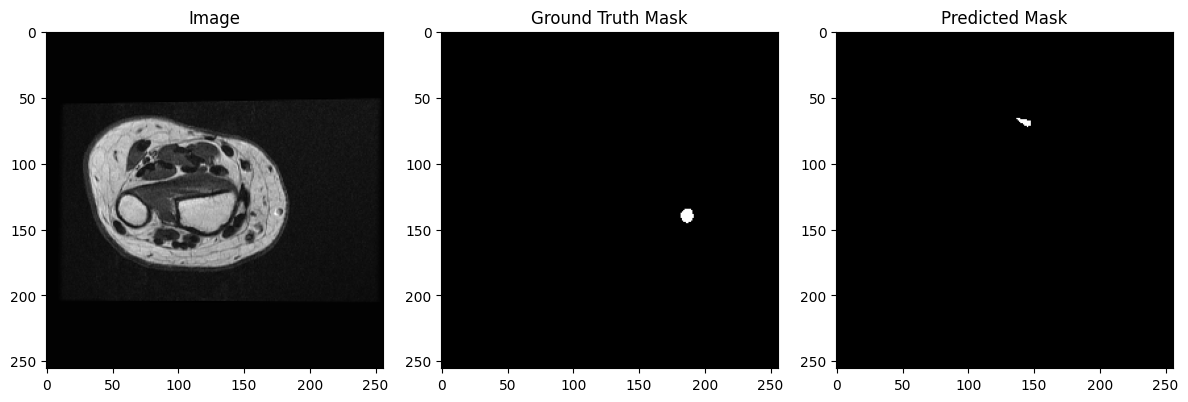

Dice score: 0.0


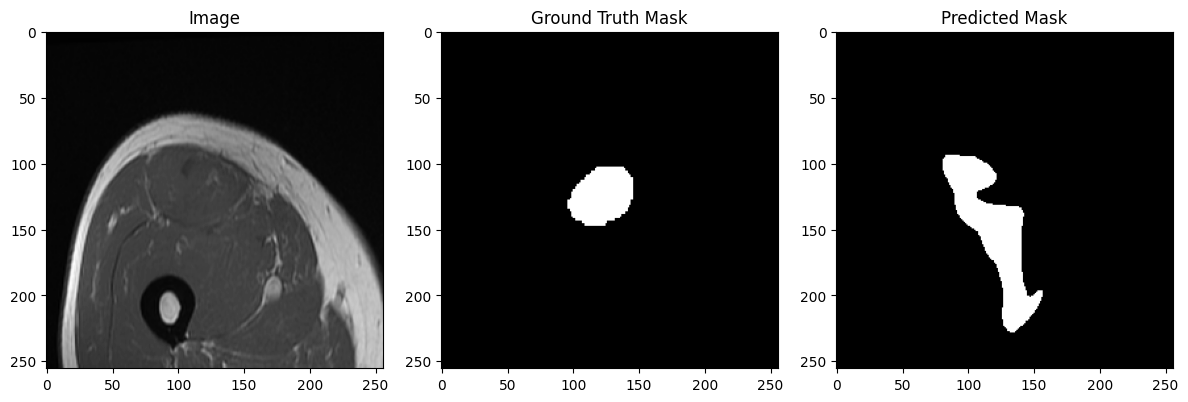

Dice score: 0.31176470582504323


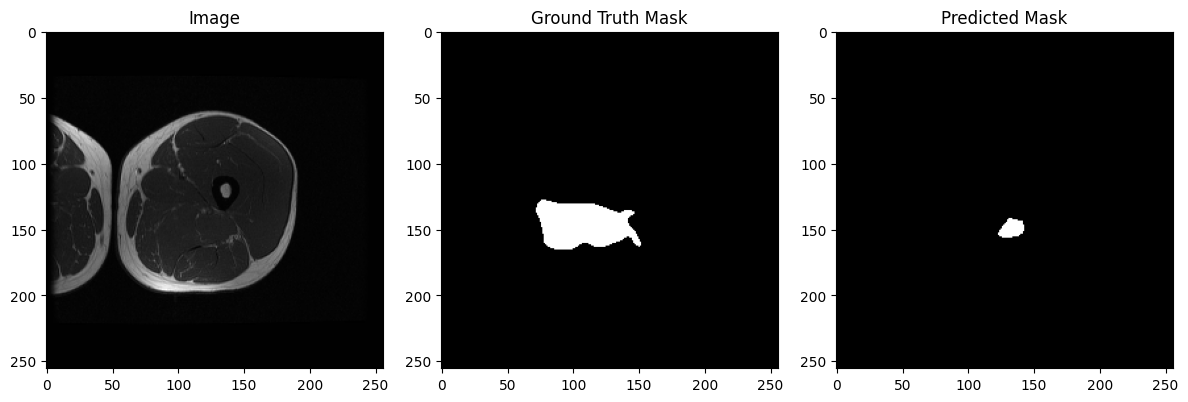

Dice score: 0.18127911894058488


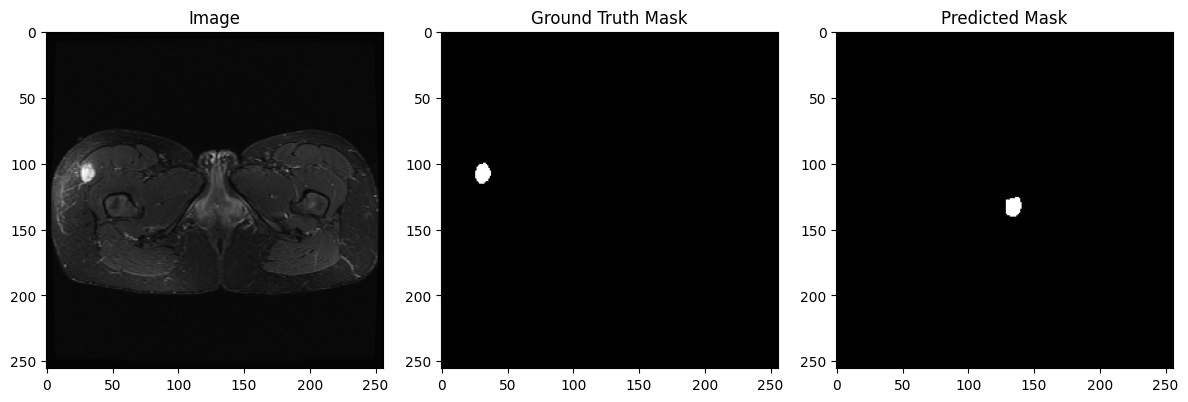

Dice score: 0.0


In [33]:
plot_predictions(img_dir, mask_dir, post_predict_dir, 10)

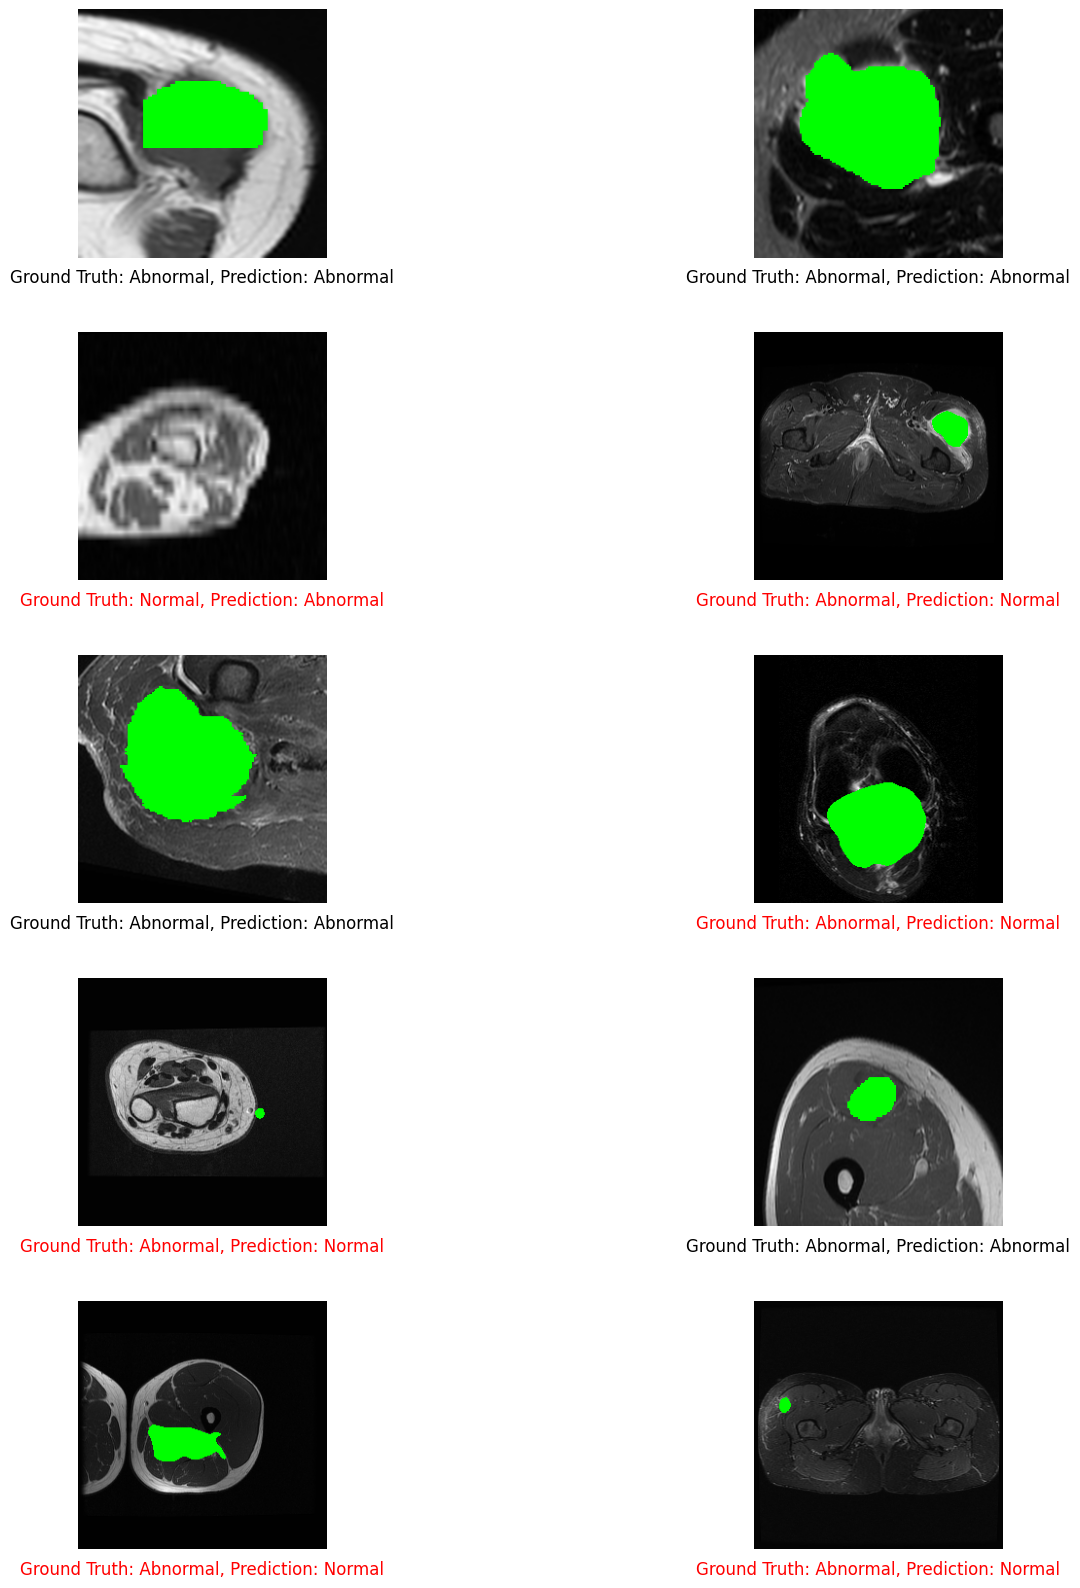

In [164]:
overlay_images(img_dir, mask_dir, post_predict_dir, 10)

### PT

Evaluation (with post-processing)

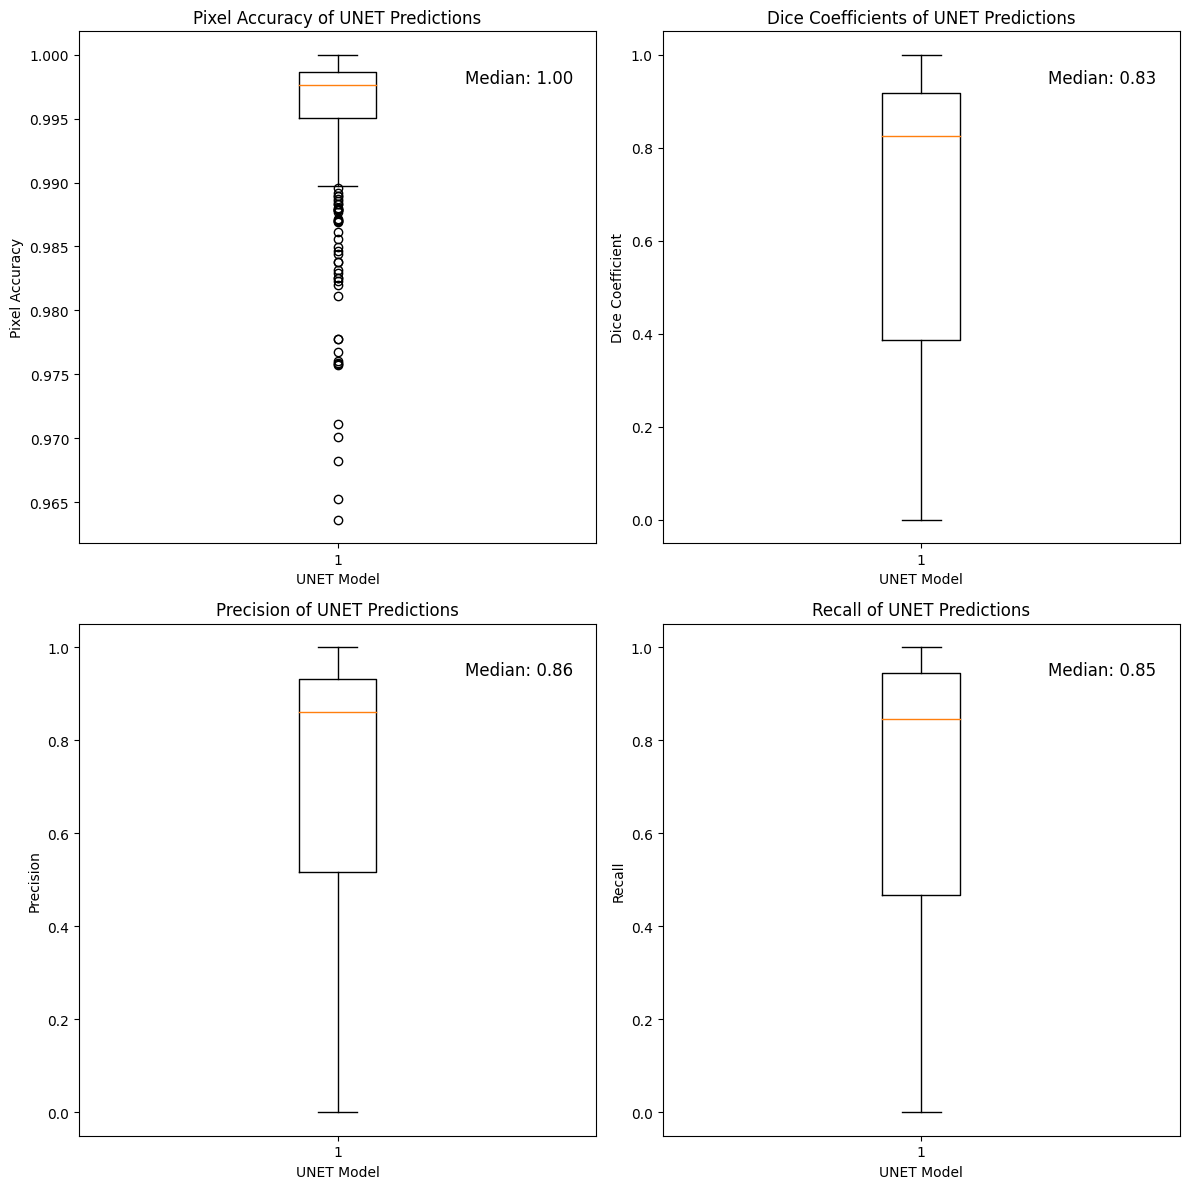

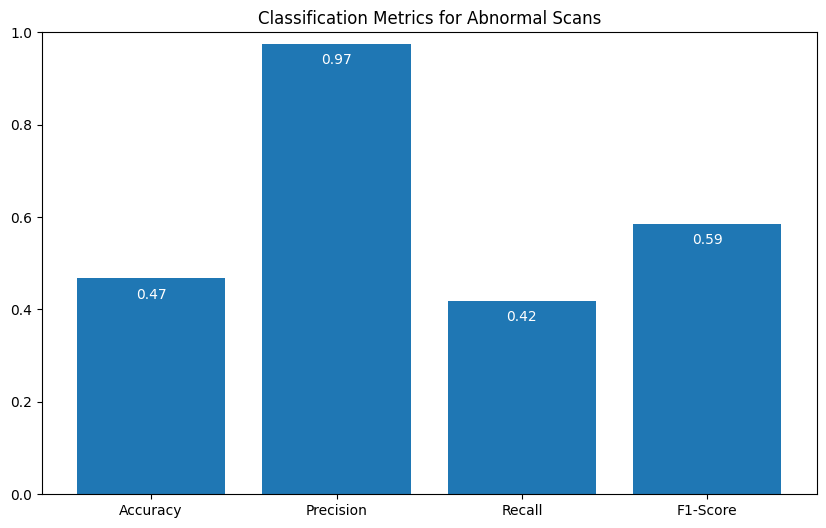

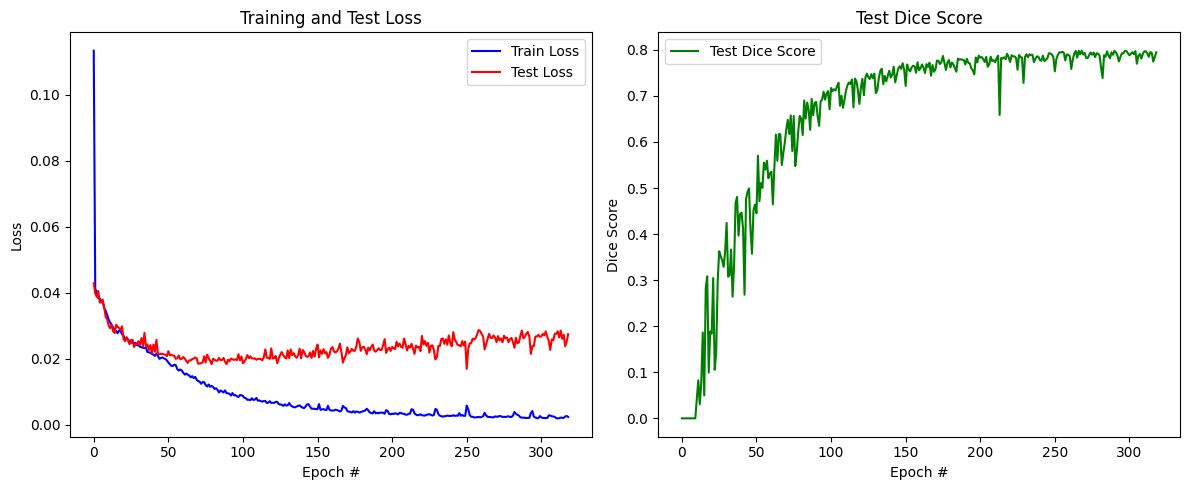

In [162]:
# Define the directories
img_dir = 'dataset_pt/test/images'
mask_dir = 'dataset_pt/test/mask'
post_predict_dir = 'dataset_pt/test/predict_unet_postprocess'
predict_dir = 'dataset_pt/test/predict_unet'
training_history_dir = 'dataset_pt/model_unet/history.pkl'

plot_all_metrics(mask_dir, predict_dir)
get_abnormality_matrix_and_plot_metrics(mask_dir, predict_dir)
plot_curves(training_history_dir)

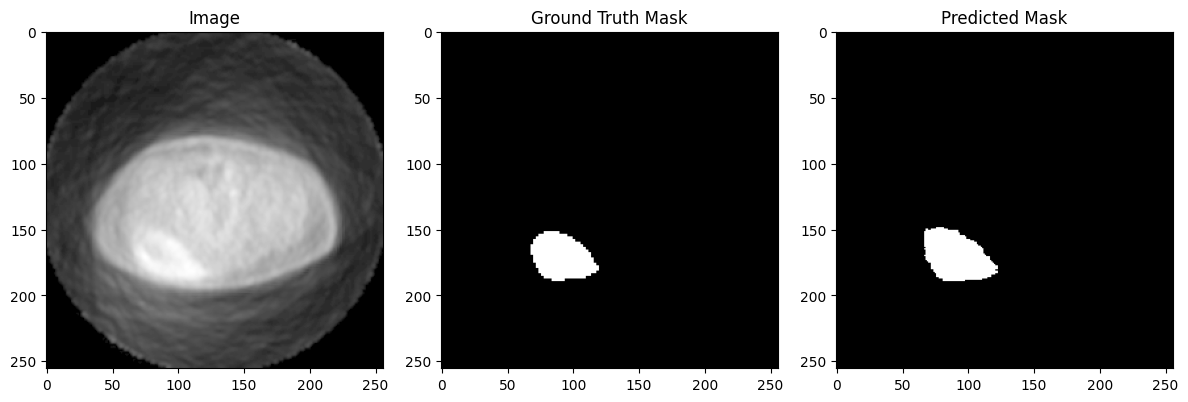

Dice score: 0.9226701913672604


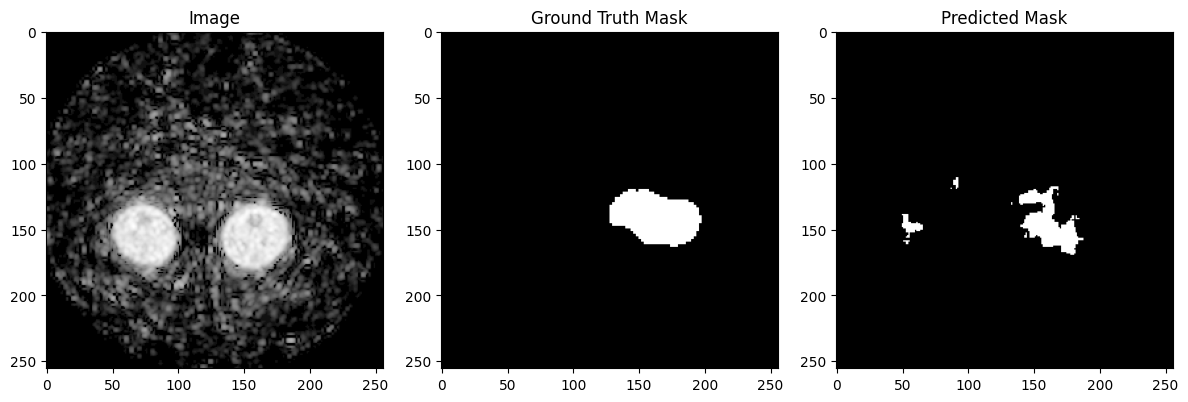

Dice score: 0.5825464948261669


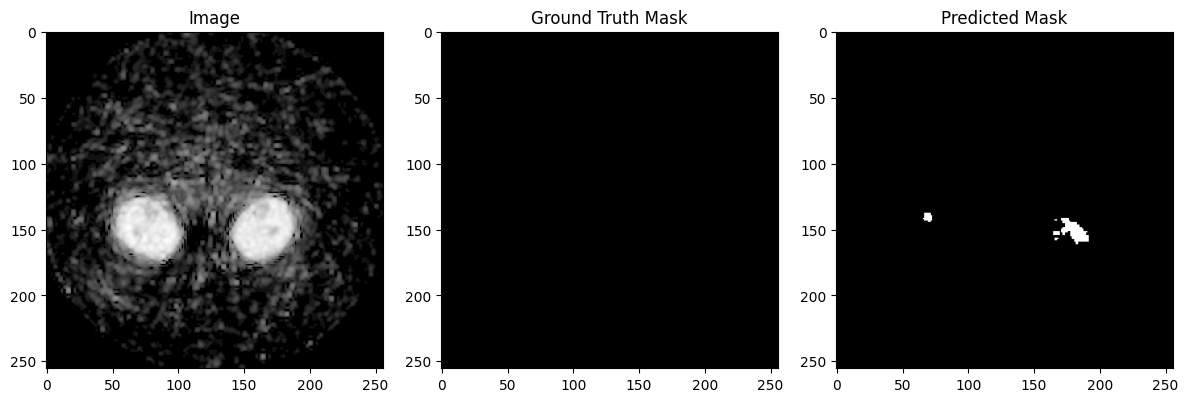

Dice score: 0.0


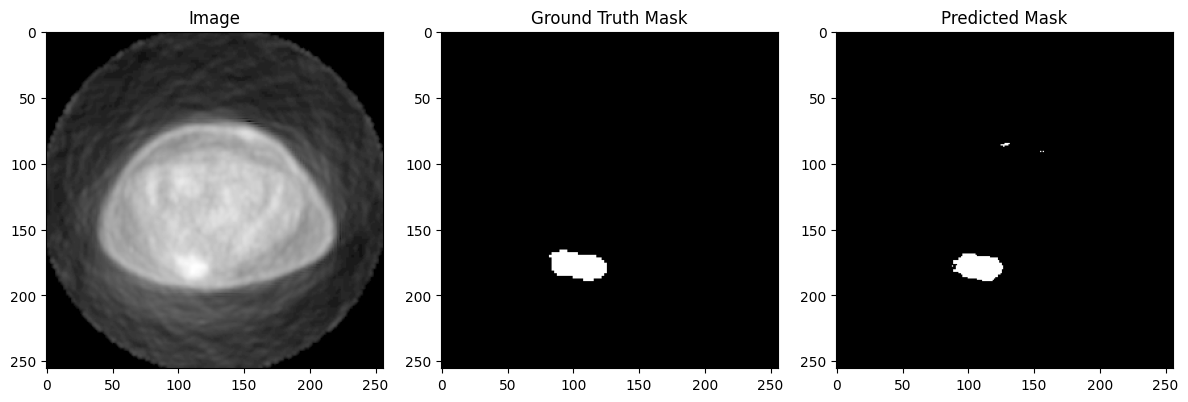

Dice score: 0.8413998504531646


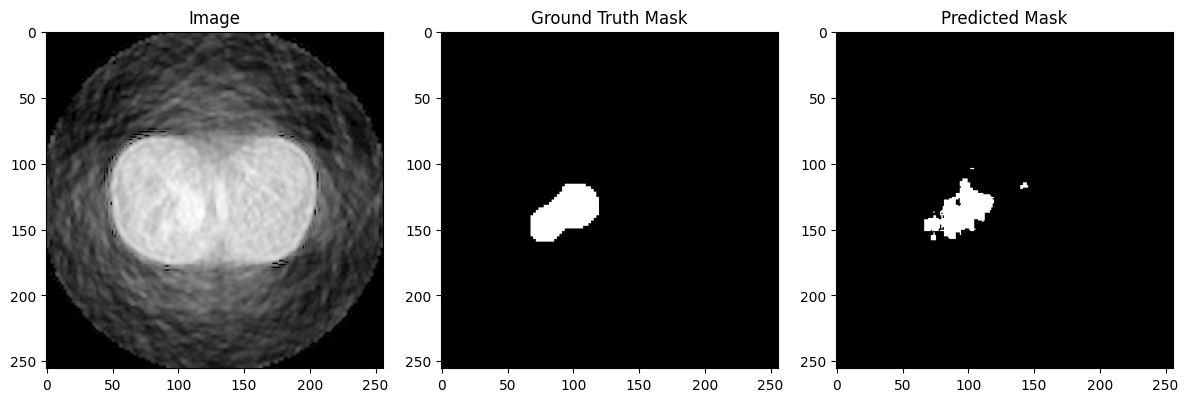

Dice score: 0.8256333827028192


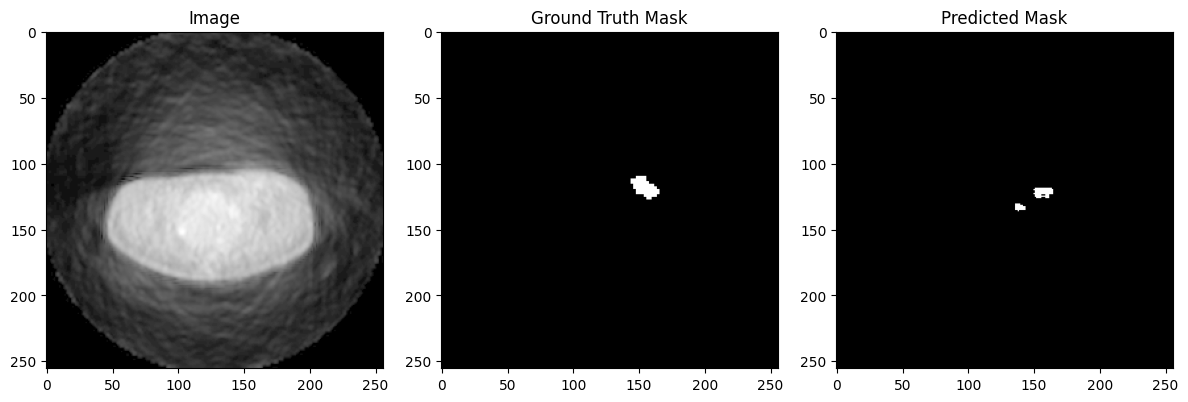

Dice score: 0.4619565204838138


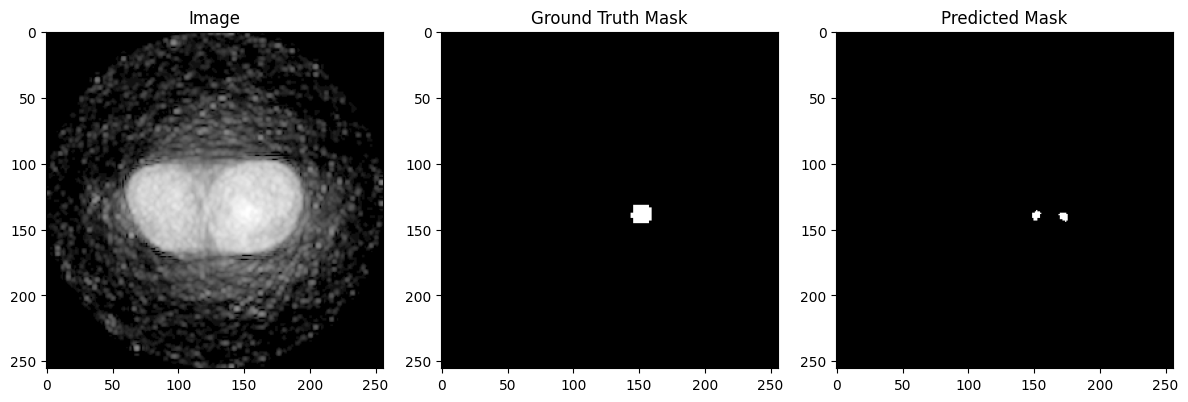

Dice score: 0.2696629203383411


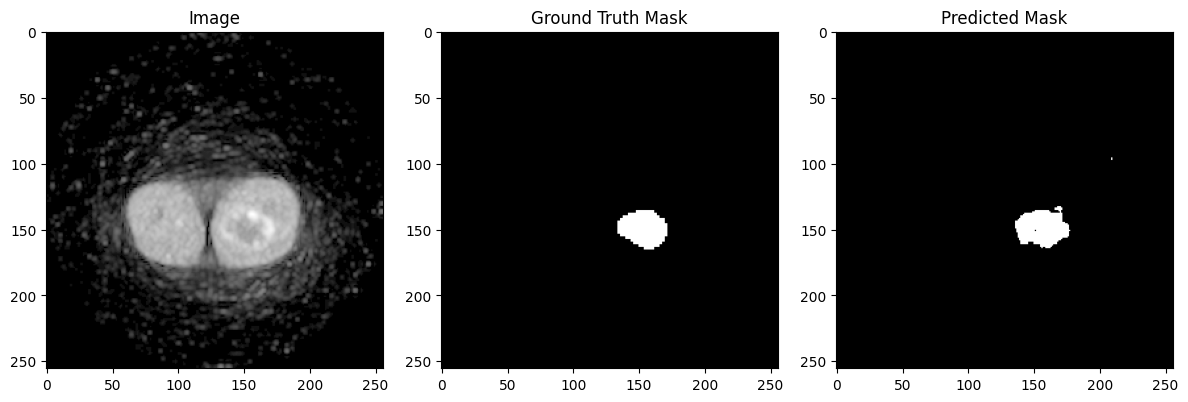

Dice score: 0.8745031227288455


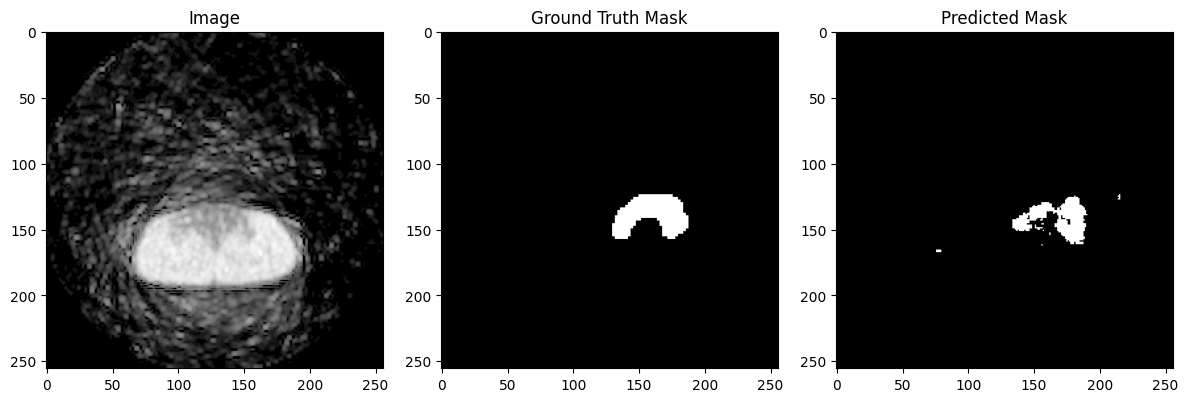

Dice score: 0.6693121690170581


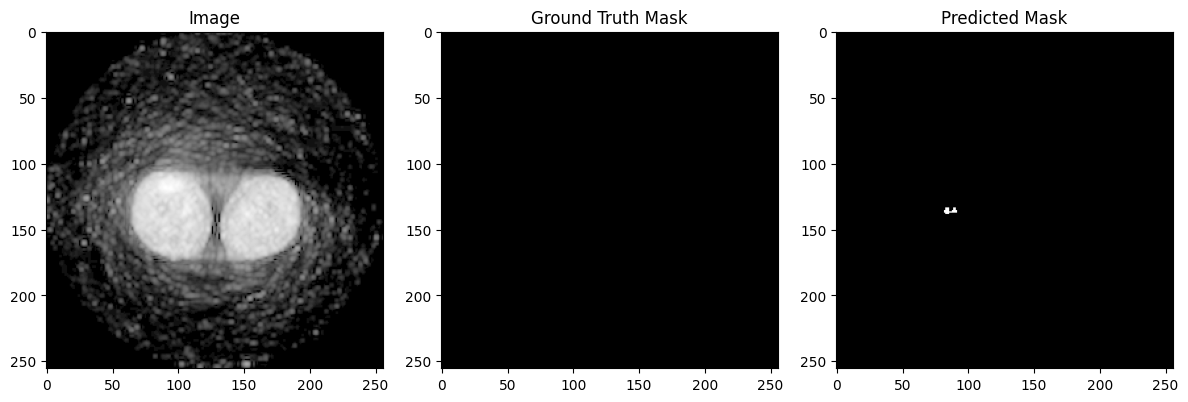

Dice score: 0.0


In [148]:
plot_predictions(img_dir, mask_dir, predict_dir, 10)

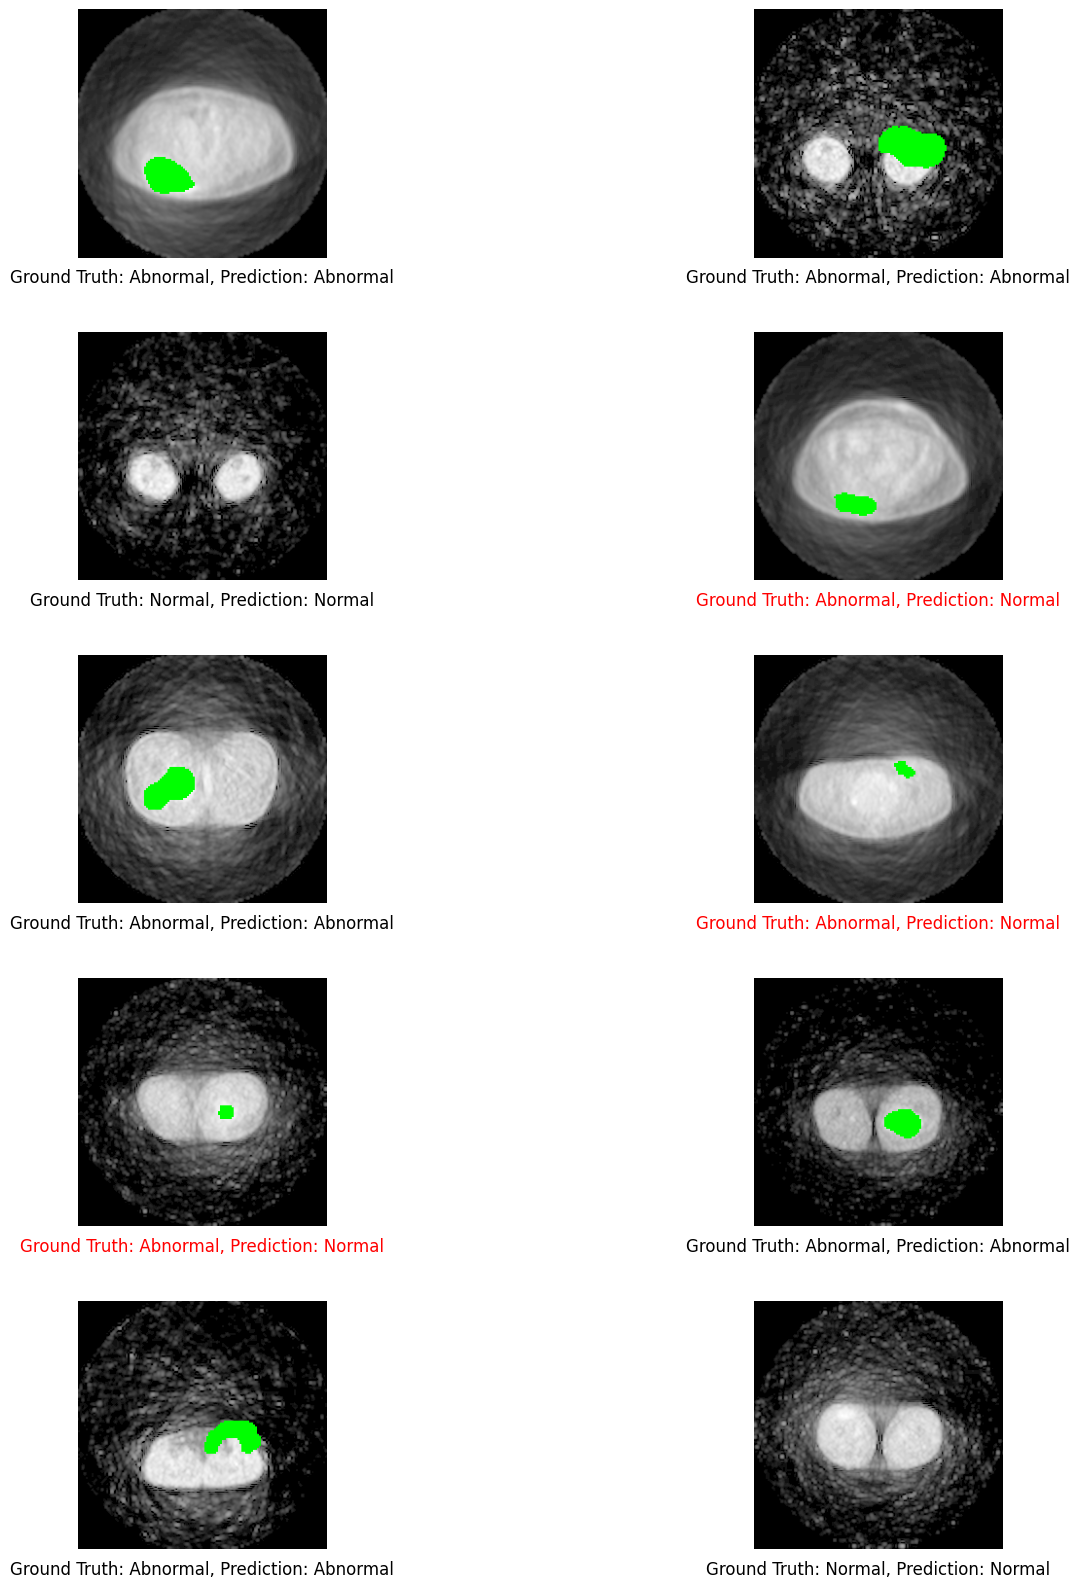

In [160]:
overlay_images(img_dir, mask_dir, predict_dir, 10)

### CT

Evaluation (with post-processing)

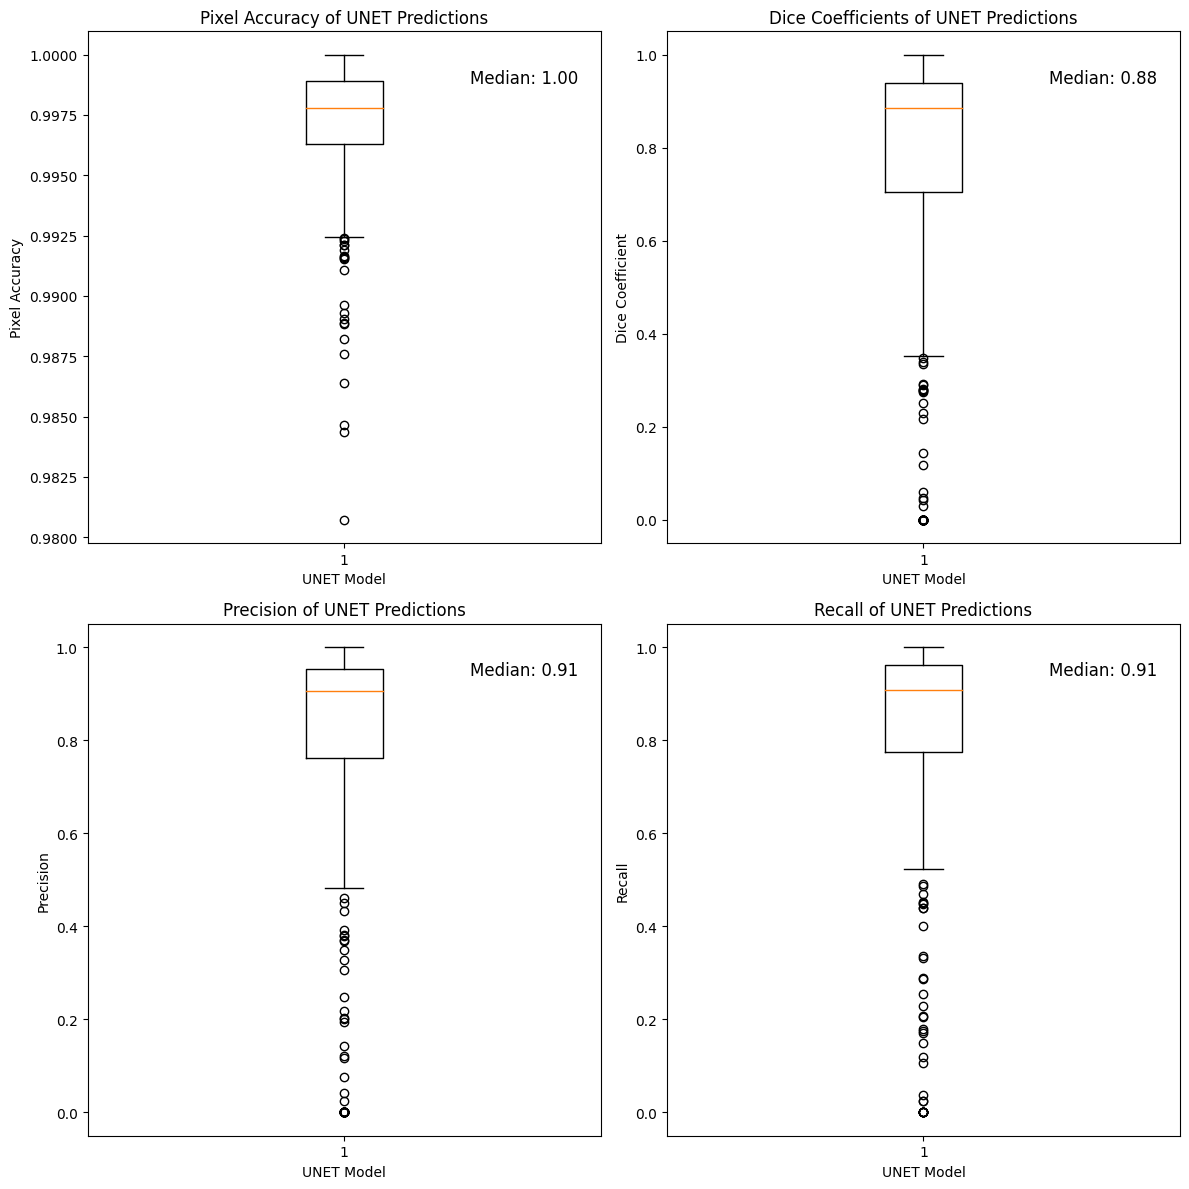

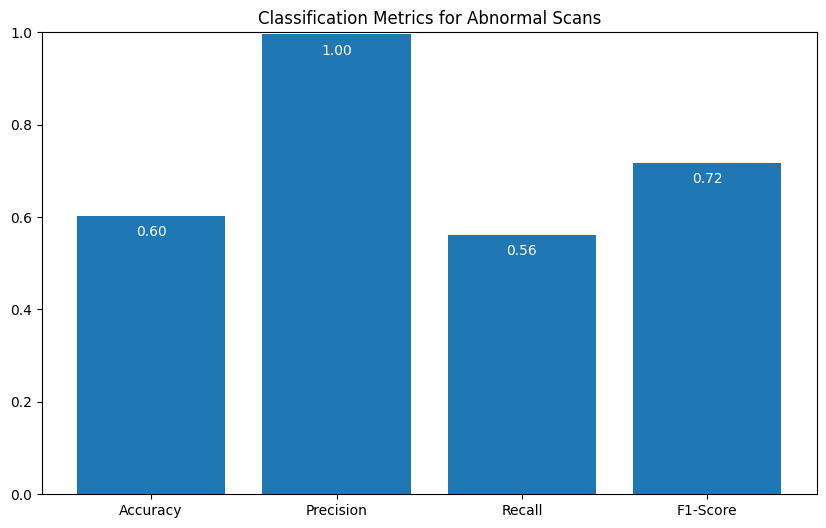

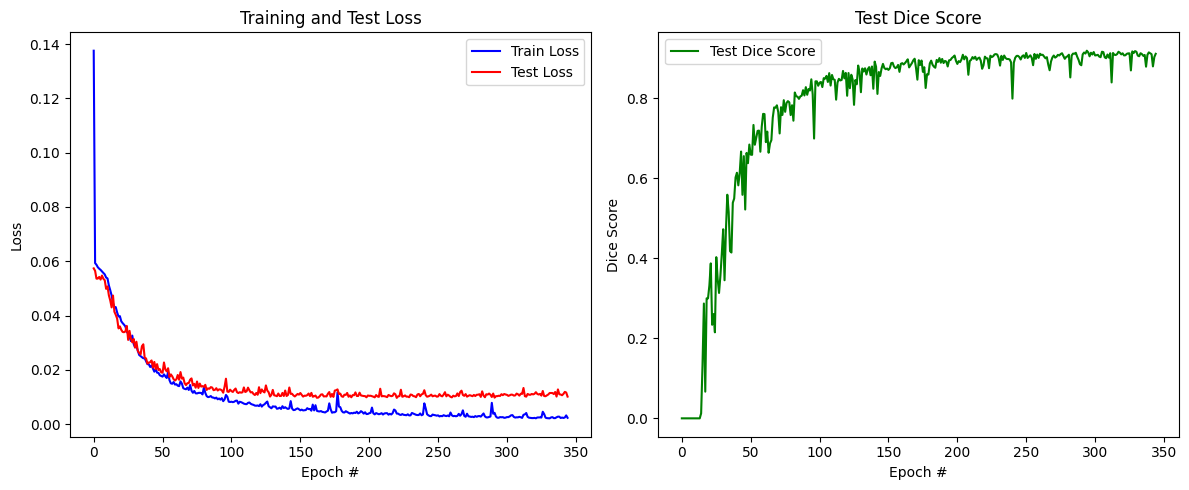

In [165]:
# Define the directories
img_dir = 'dataset_ct/test/images'
mask_dir = 'dataset_ct/test/mask'
post_predict_dir = 'dataset_ct/test/predict_unet_postprocess'
predict_dir = 'dataset_ct/test/predict_unet'
training_history_dir = 'dataset_ct/model_unet/history.pkl'

plot_all_metrics(mask_dir, predict_dir)
get_abnormality_matrix_and_plot_metrics(mask_dir, predict_dir)
plot_curves(training_history_dir)

Show the first 10 images with predicted mask (with post-processing) along with ground truth

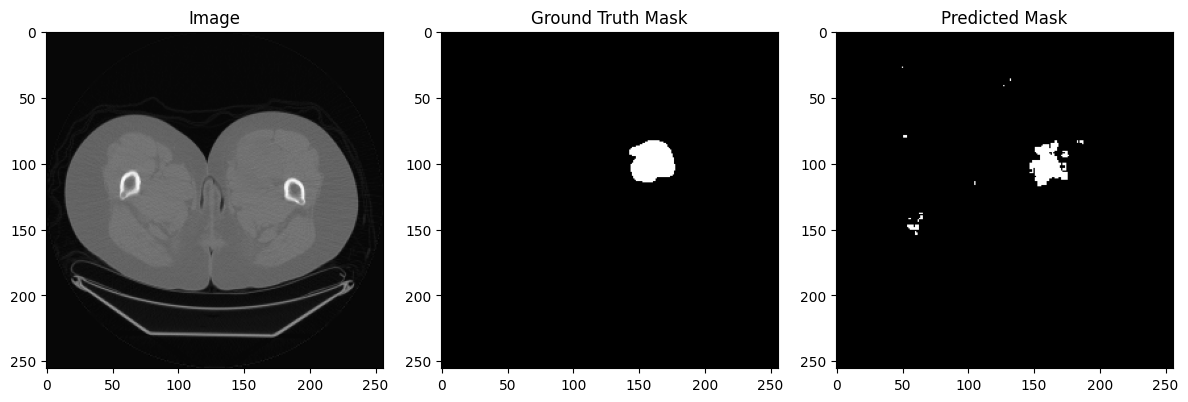

Dice score: 0.7136273859686455


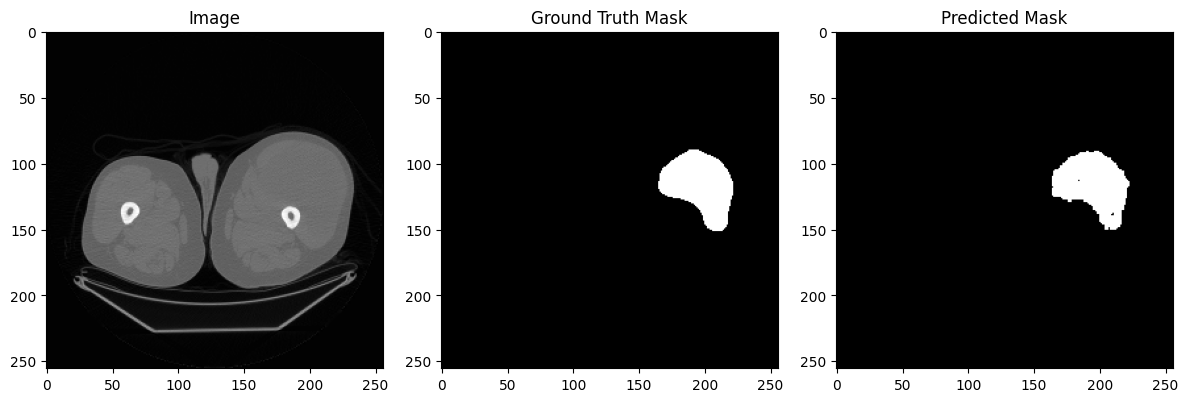

Dice score: 0.9577336072749065


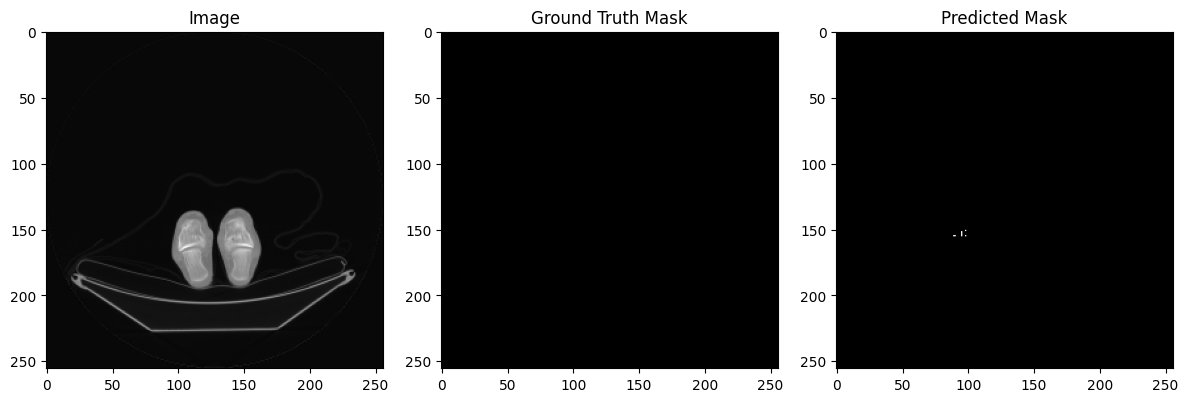

Dice score: 0.0


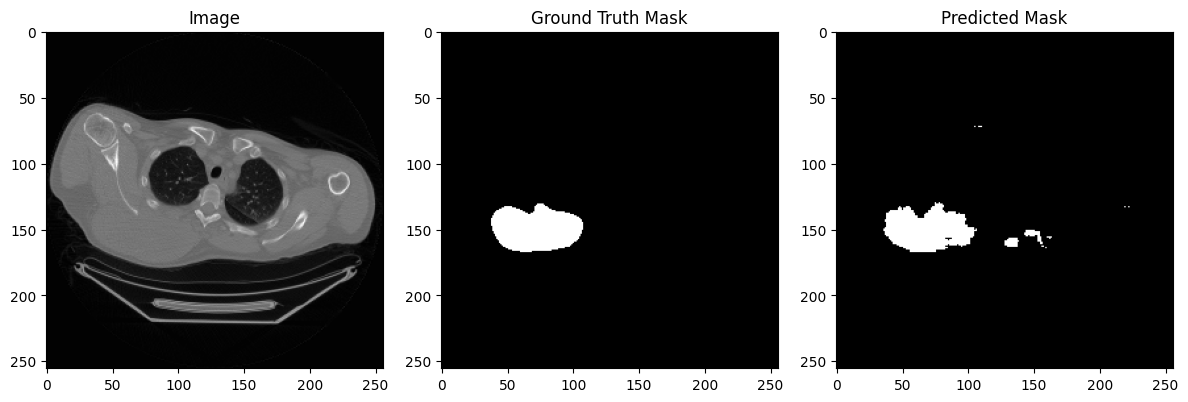

Dice score: 0.8892315597817447


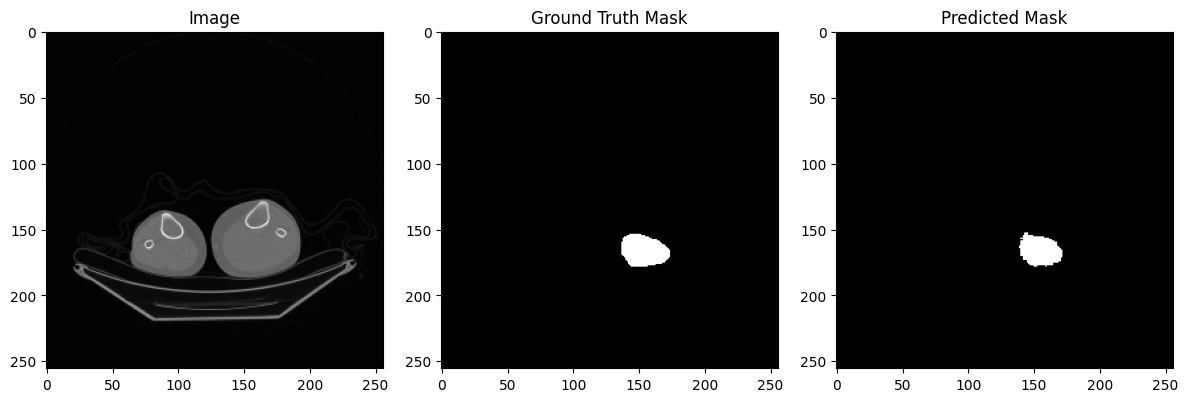

Dice score: 0.9092273061446156


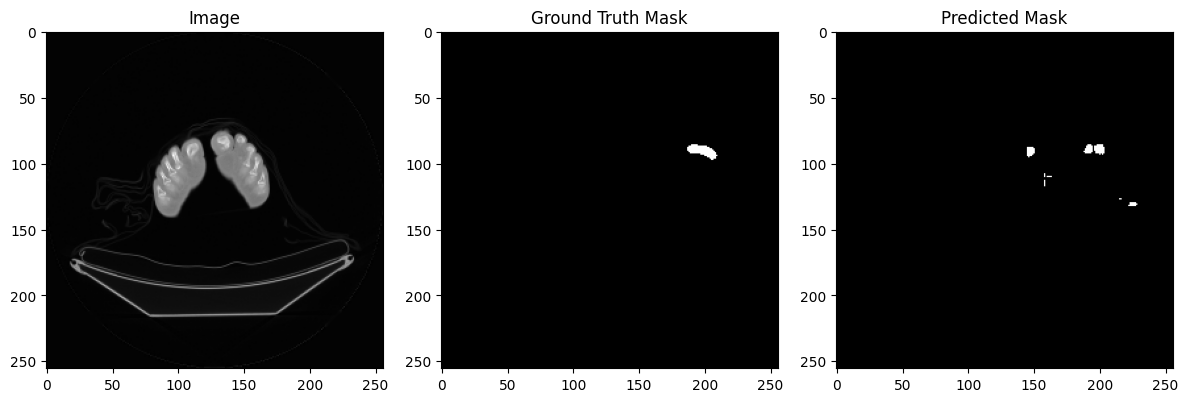

Dice score: 0.5354838692403746


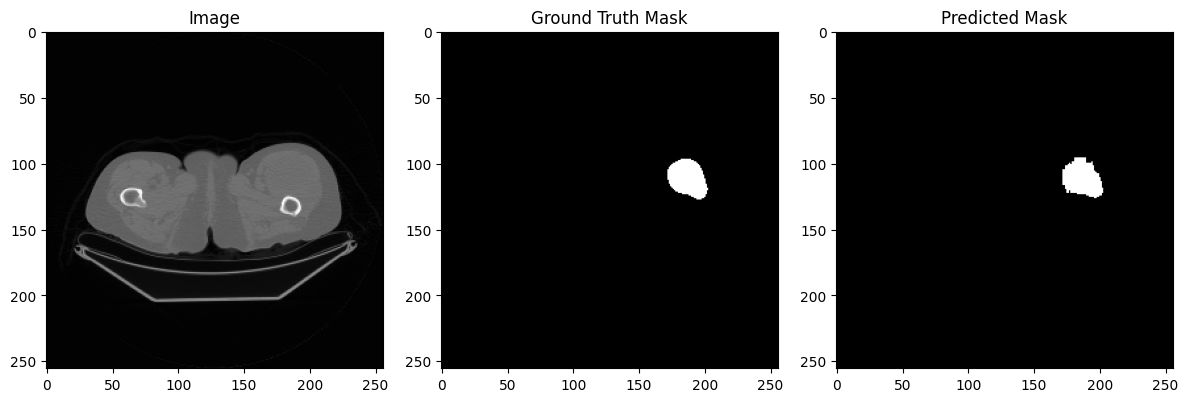

Dice score: 0.9475982525854452


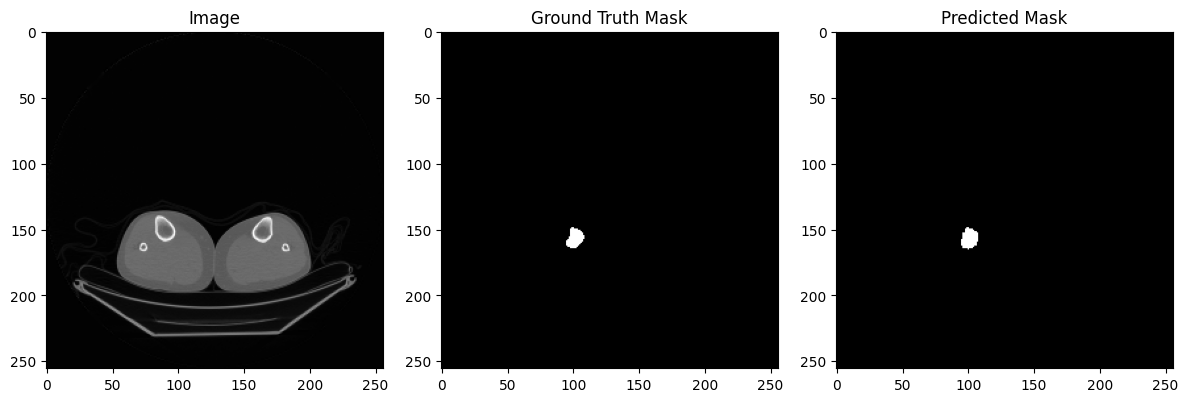

Dice score: 0.9333333303703704


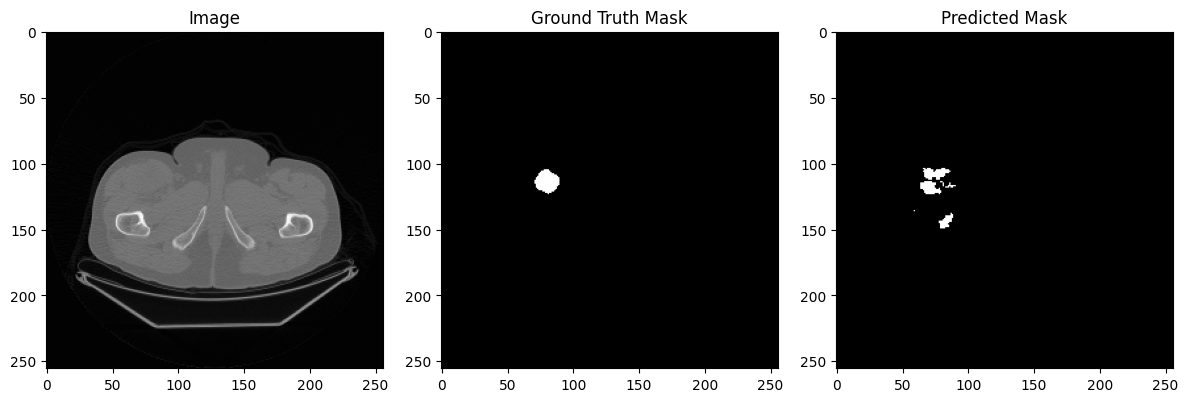

Dice score: 0.34782608635160683


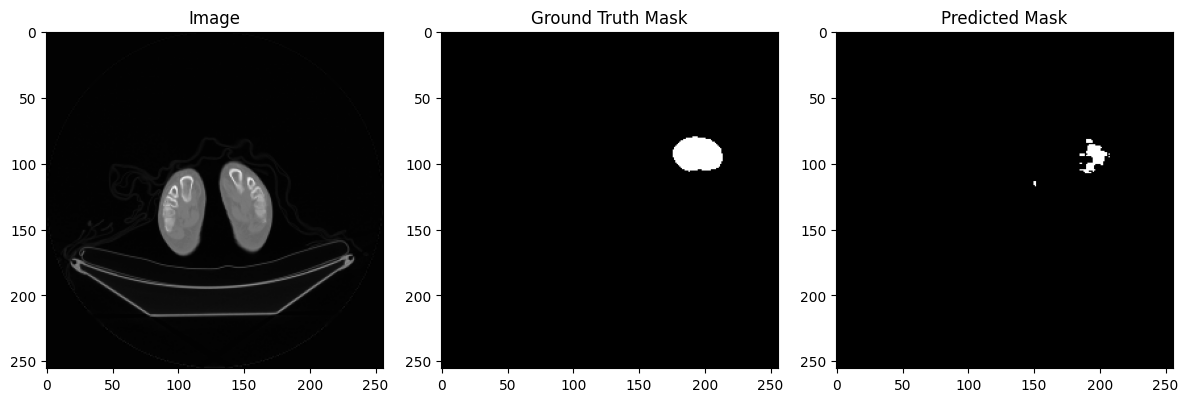

Dice score: 0.43804034540053755


In [78]:
plot_predictions(img_dir, mask_dir, predict_dir, 10)

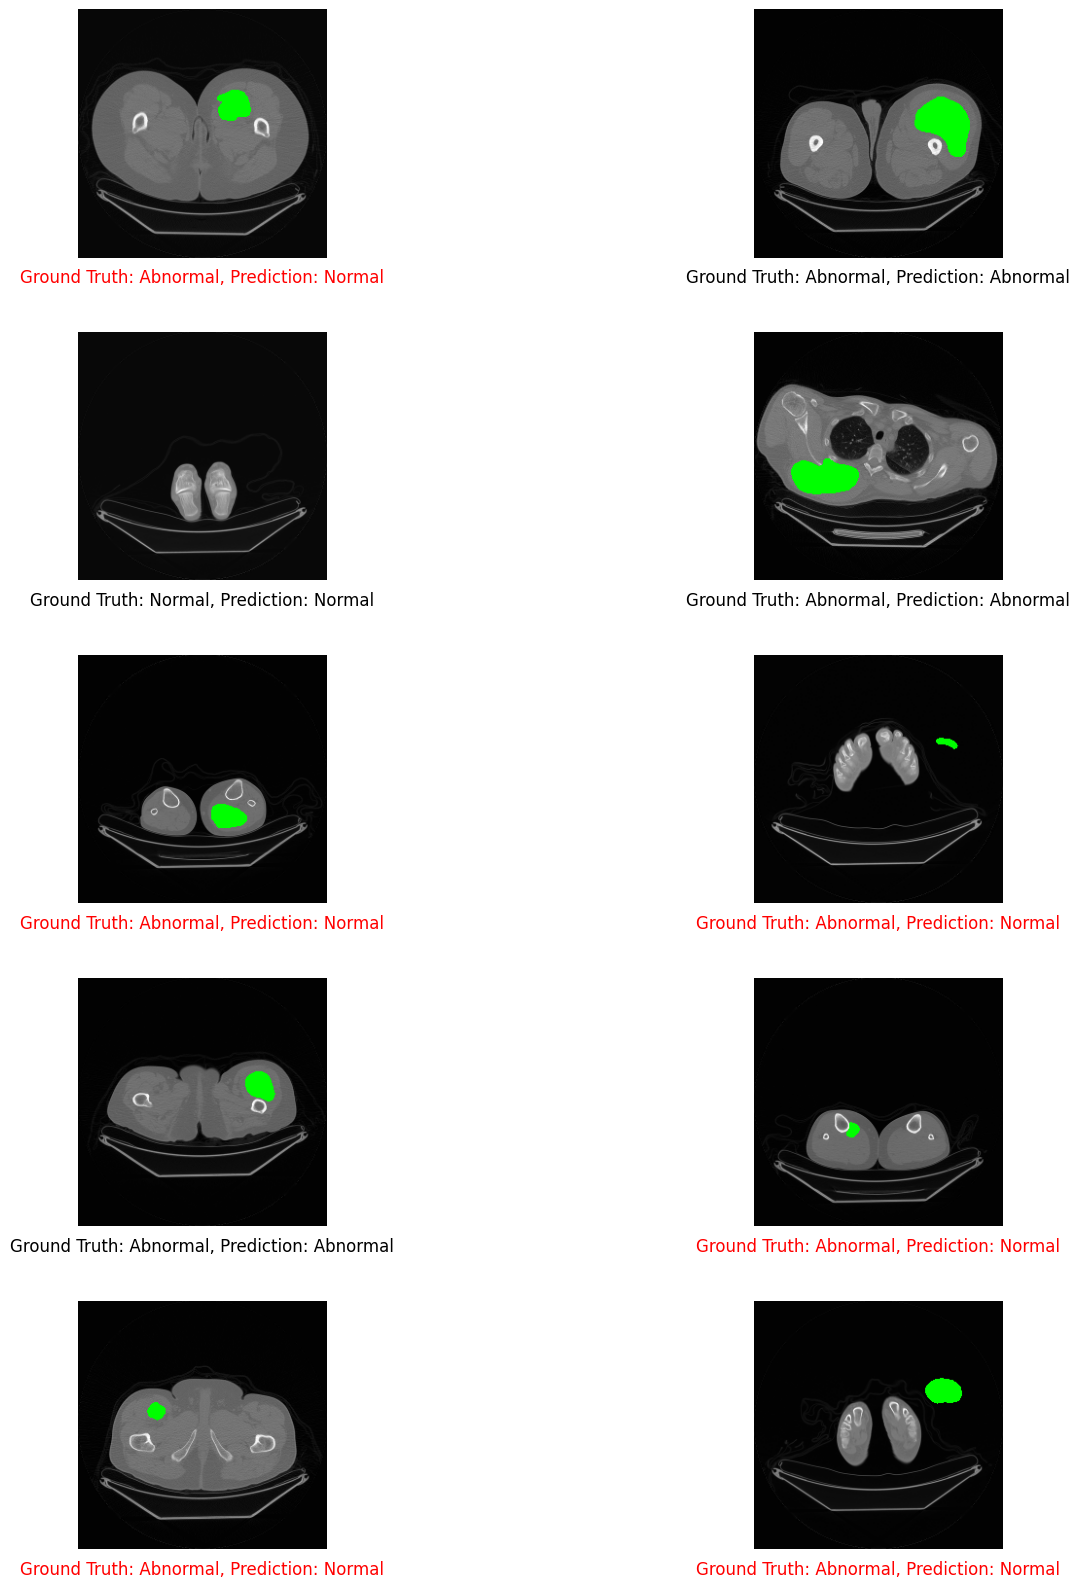

In [166]:
overlay_images(img_dir, mask_dir, predict_dir, 10)

### Combined

Evaluation

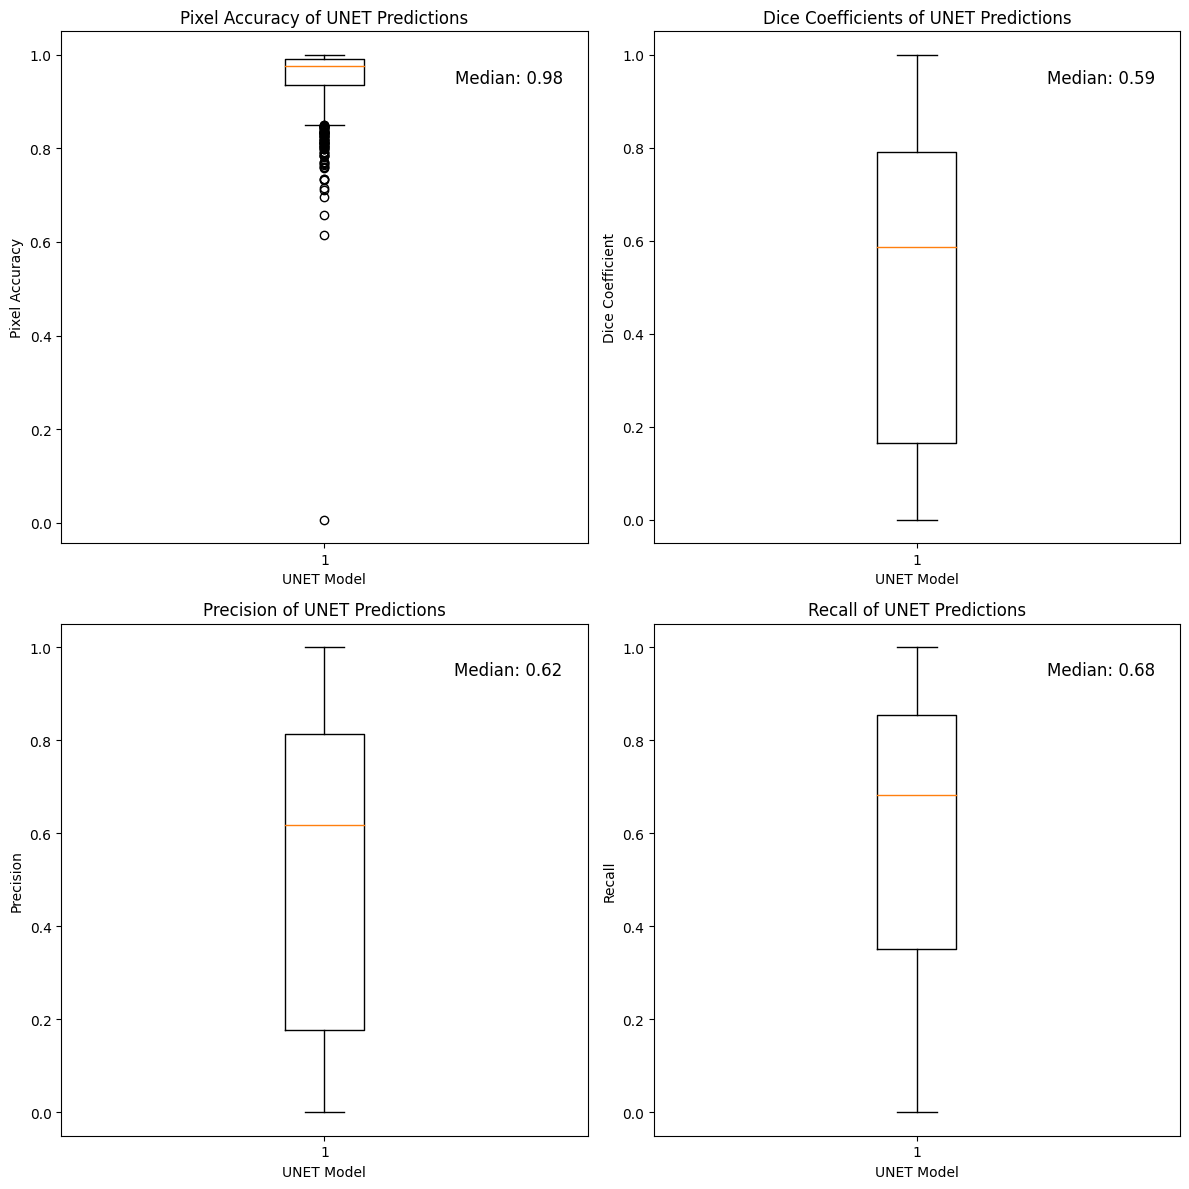

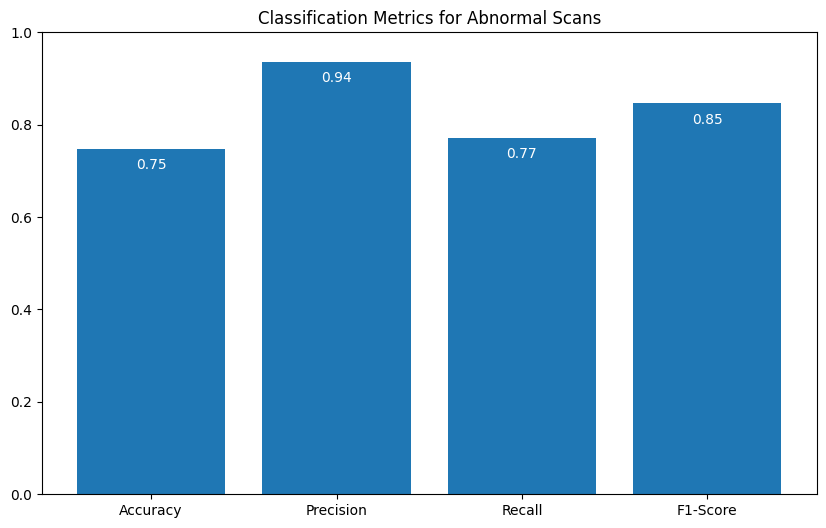

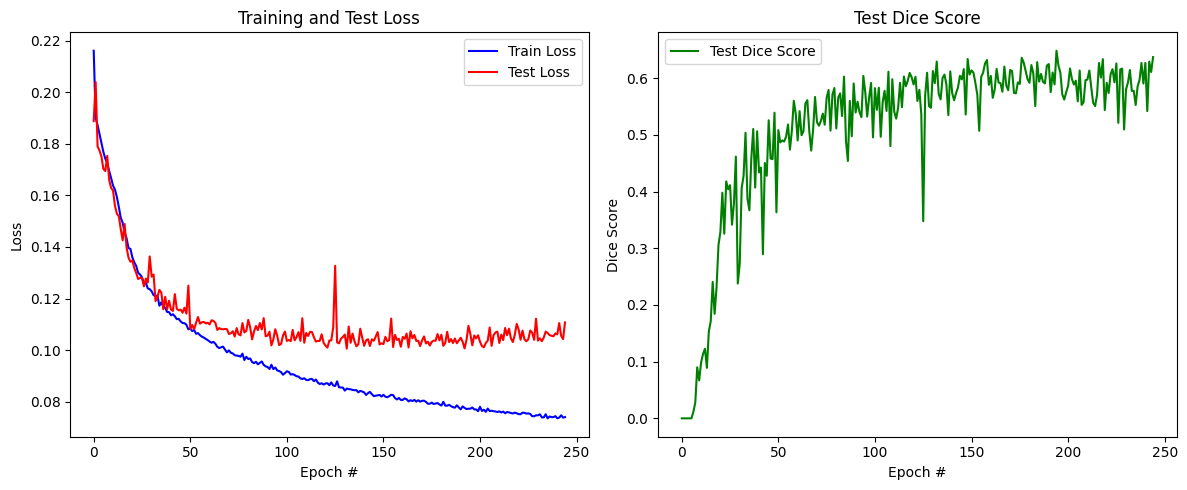

In [167]:
# Define the directories
img_dir = 'dataset_combined/test/images'
mask_dir = 'dataset_combined/test/mask'
post_predict_dir = 'dataset_combined/test/predict_unet_postprocess'
predict_dir = 'dataset_combined/test/predict_unet'
training_history_dir = 'dataset_combined/model_unet/history.pkl'

plot_all_metrics(mask_dir, predict_dir)
get_abnormality_matrix_and_plot_metrics(mask_dir, predict_dir)
plot_curves(training_history_dir)

Show the first 10 images with predicted mask (with post-processing) along with ground truth

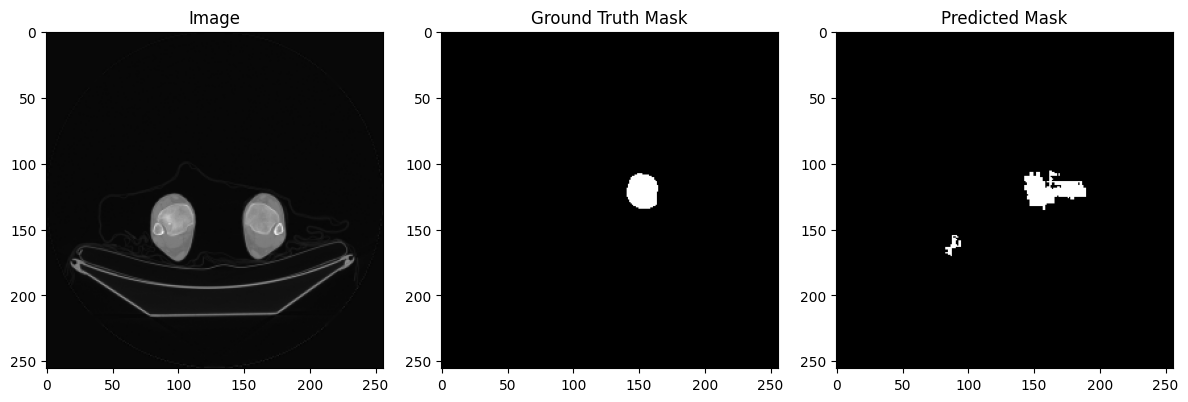

Dice score: 0.6022471905601144


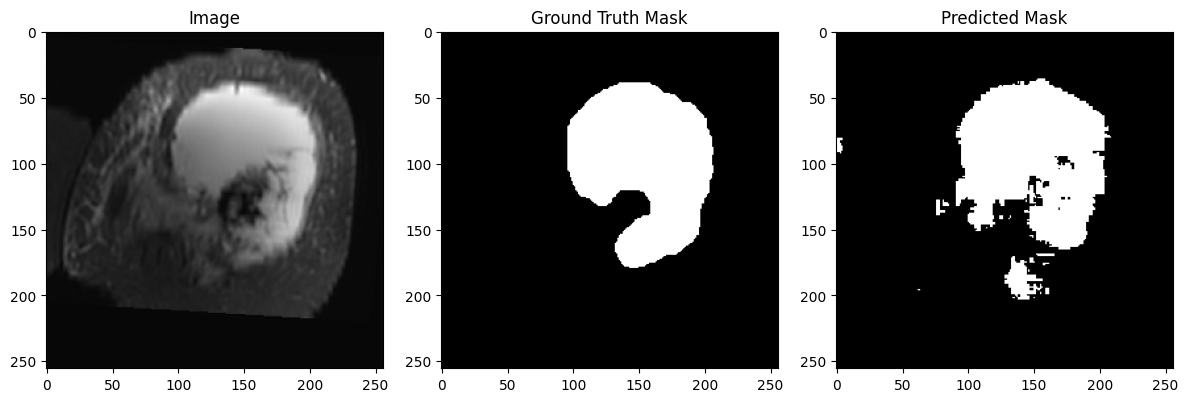

Dice score: 0.8652255380985684


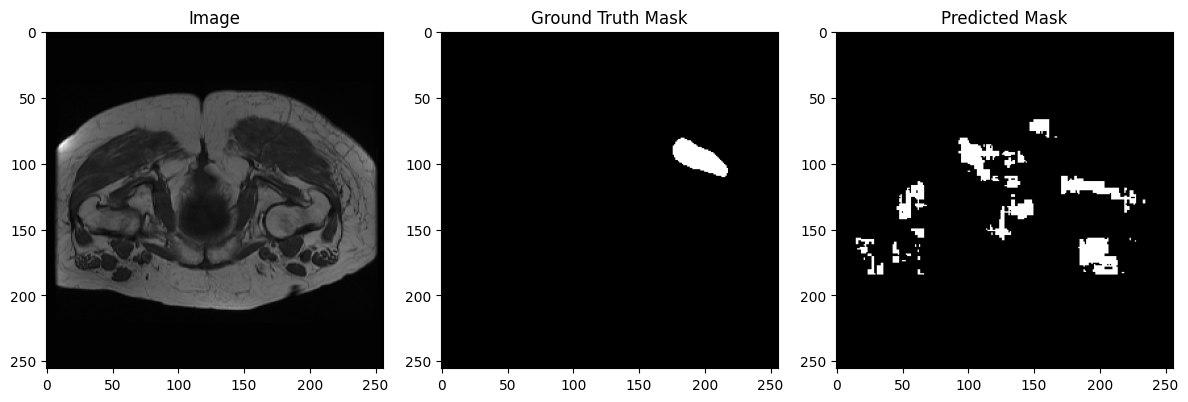

Dice score: 0.0


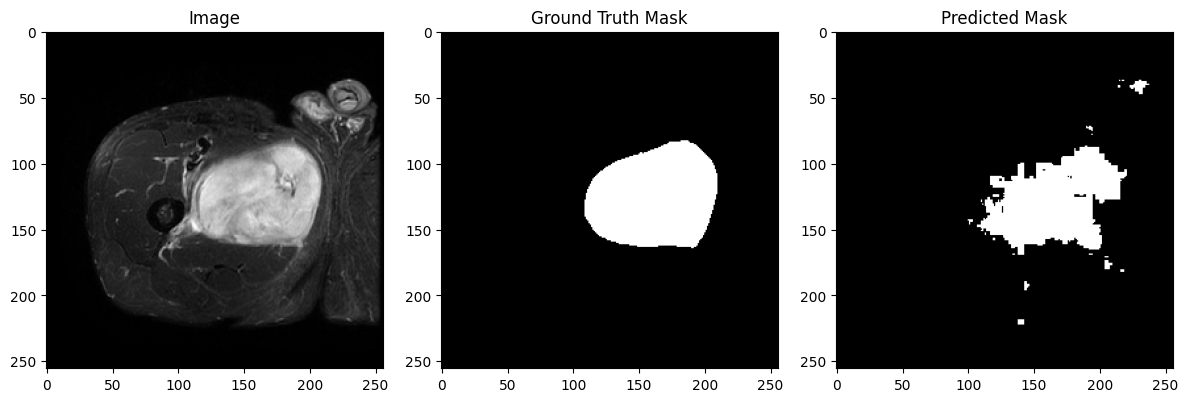

Dice score: 0.8381680657602719


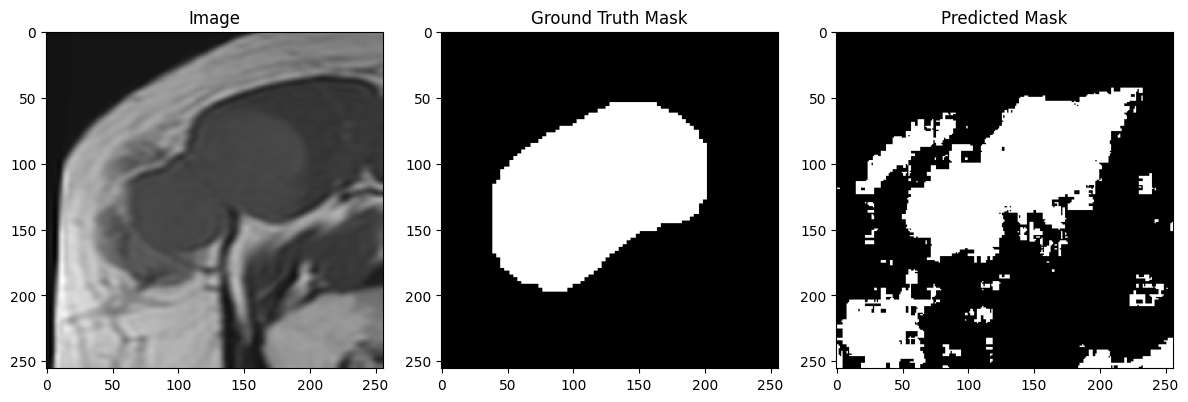

Dice score: 0.6273648941212743


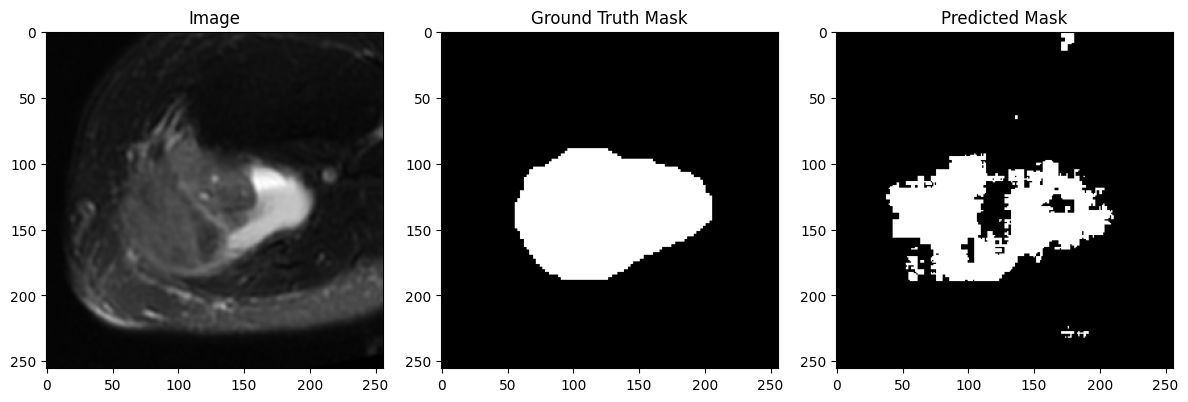

Dice score: 0.7957718780336395


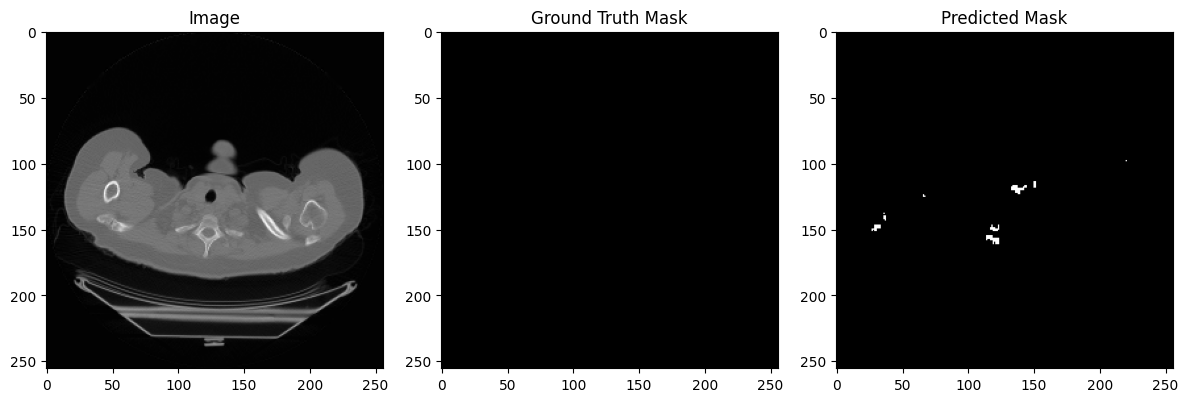

Dice score: 0.0


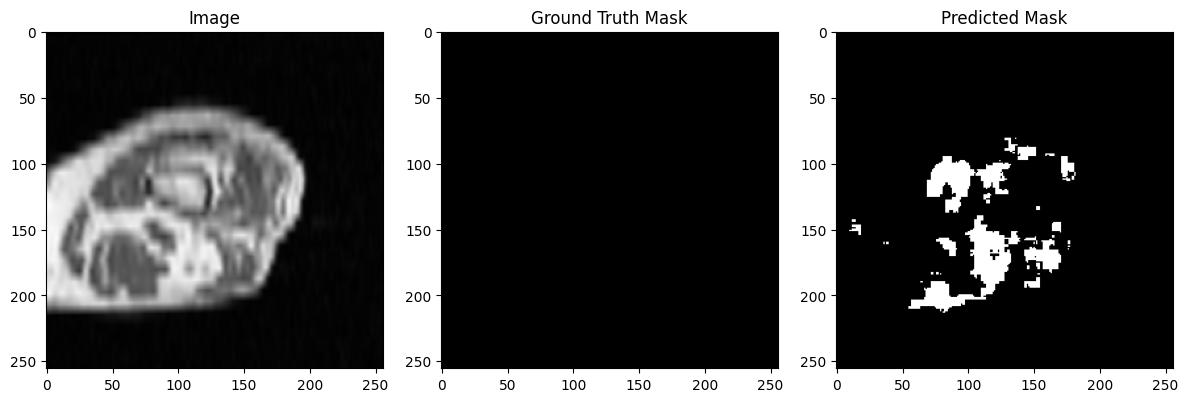

Dice score: 0.0


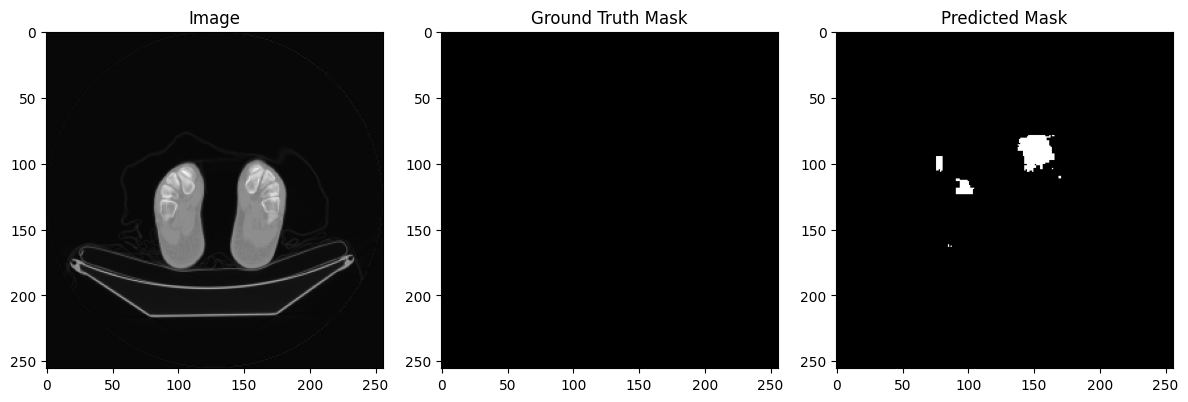

Dice score: 0.0


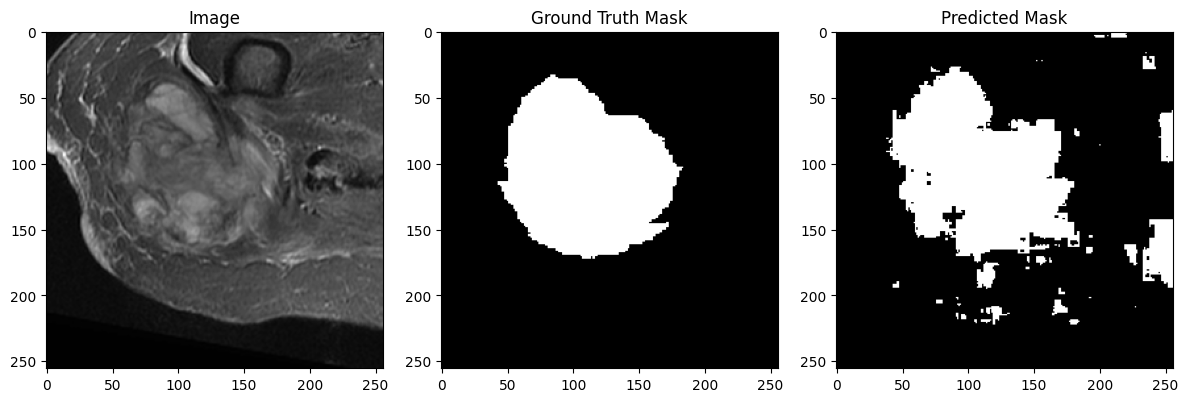

Dice score: 0.8385584324409182


In [82]:
plot_predictions(img_dir, mask_dir, predict_dir, 10)

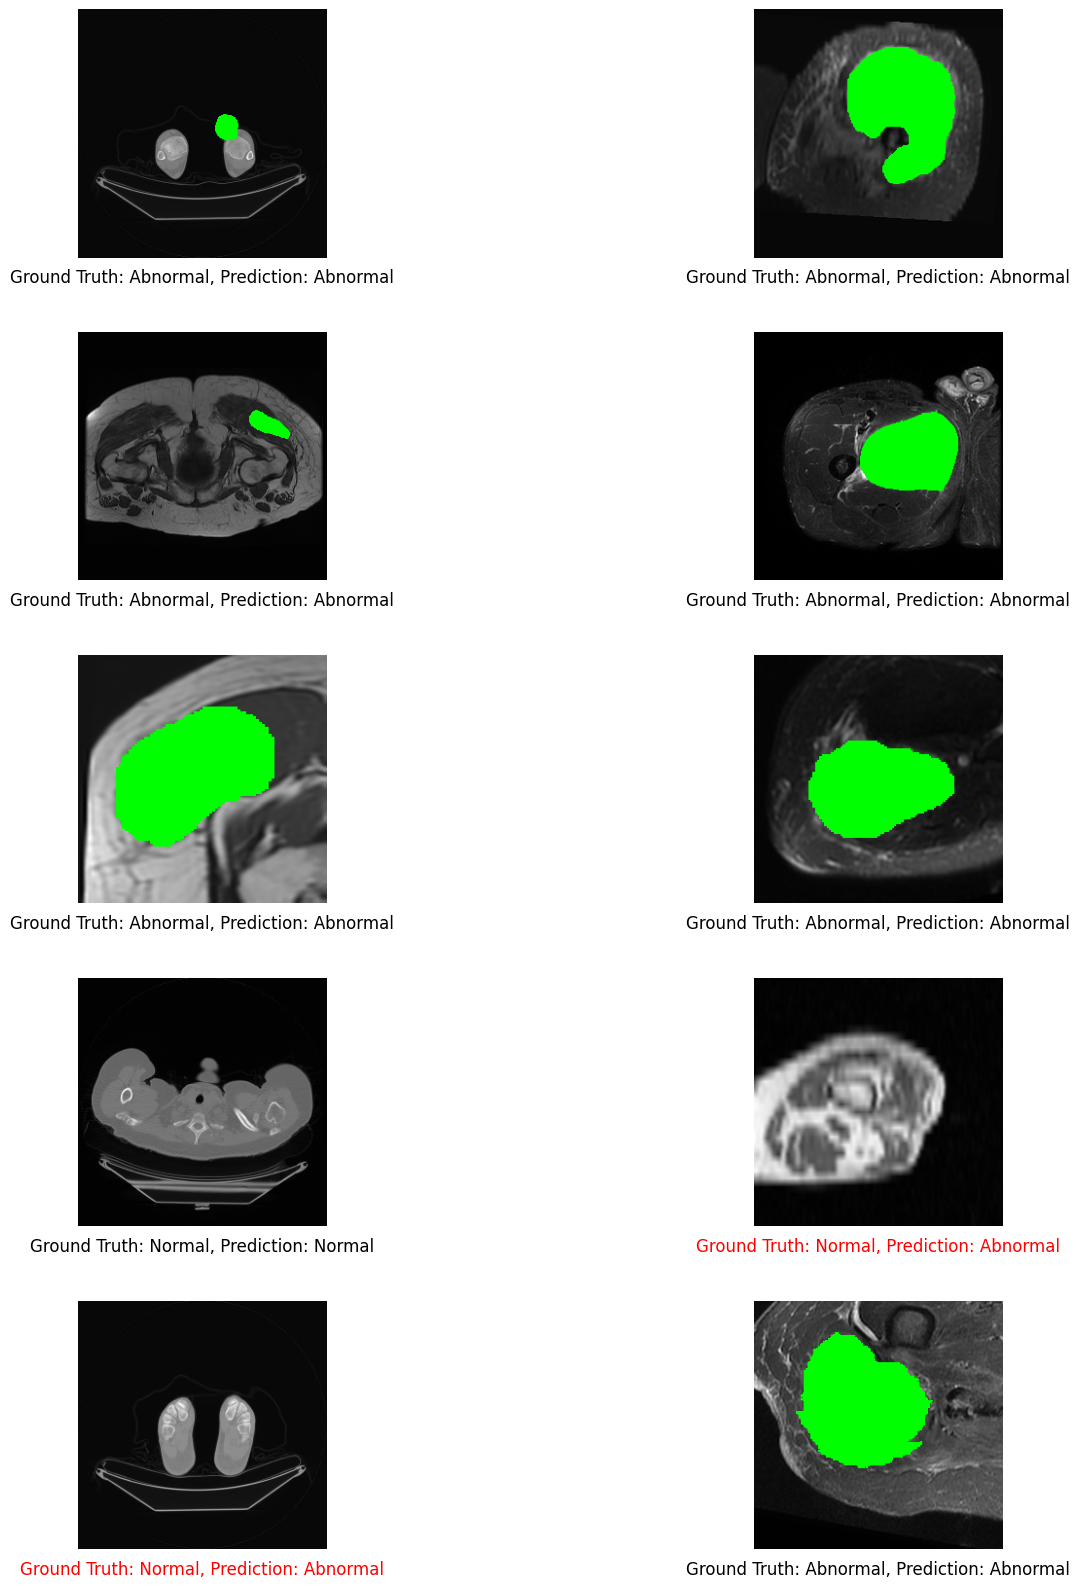

In [168]:
overlay_images(img_dir, mask_dir, predict_dir, 10)